<a href="https://www.kaggle.com/code/nahidhasan0nh/model5?scriptVersionId=289887411" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Clearing the environment

try:
    del full_dataset, train_indices, val_indices, train_subset, val_subset, train_loader, val_loader, labels, class_names, model, criterion, optimizer
except NameError:
    print("Some are non-existent!")

!rm -rf /kaggle/working/*
%reset -f


import gc


def reset_memory():
    # Delete all variables.
    for var in gc.get_objects():
        try:
            del var
        except:
        
            pass

    # Run the garbage collector.
    gc.collect()

    print("Memory has been reset")

# Call the function to reset memory

reset_memory()

Some are non-existent!
Memory has been reset


In [2]:
# 1. IMPORTS
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


2026-01-03 17:26:25.780151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767461185.959216      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767461186.011041      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
# 2. CONFIG

ROOT_DIR = "/kaggle/input/tomato-diseases"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42
VALID_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".gif")

In [4]:
# 3. COLLECT ALL IMAGES & LABELS

class_names = sorted(os.listdir(os.path.join(ROOT_DIR, "train")))
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

all_image_paths, all_labels = [], []

for cls in class_names:
    cls_path = os.path.join(ROOT_DIR, "train", cls)
    if not os.path.exists(cls_path):
        continue
    for f in os.listdir(cls_path):
        if f.lower().endswith(VALID_EXTS):
            path = os.path.join(cls_path, f)
            if os.path.getsize(path) > 0:
                all_image_paths.append(path)
                all_labels.append(class_to_idx[cls])

image_paths = np.array(all_image_paths)
labels = np.array(all_labels)
print(f"Total images: {len(image_paths)}")

Total images: 17753


In [5]:
#Filter corrupted images
from PIL import Image

valid_paths, valid_labels = [], []

for path, label in zip(all_image_paths, all_labels):
    try:
        img = Image.open(path)
        img.verify()  # Will throw error if image is broken
        valid_paths.append(path)
        valid_labels.append(label)
    except Exception:
        print("Skipping invalid/corrupted image:", path)

# Convert to numpy arrays
image_paths = np.array(valid_paths)
labels = np.array(valid_labels)
print(f"Total valid images: {len(image_paths)}")


Total valid images: 17753


In [6]:
# Shuffle dataset
np.random.seed(SEED)
indices = np.arange(len(image_paths))
np.random.shuffle(indices)
image_paths = image_paths[indices]
labels = labels[indices]

In [7]:
# STRATIFIED TRAIN/VAL/TEST SPLIT=80/10/10

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

print(f"Total images: {len(image_paths)}")
print(f"Number of classes: {len(class_names)} -> {class_names}")
print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

Total images: 17753
Number of classes: 10 -> ['bacterial_spot', 'early_blight', 'healthy', 'late_blight', 'leaf_mold', 'mosaic_virus', 'septoria_leaf_spot', 'target_spot', 'twospotted_spider_mite', 'yellow_leaf_curl_virus']
Train: 14202, Val: 1775, Test: 1776


In [8]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# Choose preprocessing function depending on model
PREPROCESS_FN = vgg_preprocess  # or resnet_preprocess, efficientnet_preprocess

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    img = PREPROCESS_FN(img)  # model-specific preprocessing
    return img, tf.one_hot(label, len(class_names))


In [9]:
# 5. TF.DATA PIPELINE
AUTOTUNE = tf.data.AUTOTUNE

# Safe image loader
def load_image(path, label, preprocess_fn=None):
    img = tf.io.read_file(path)
    try:
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
    except:
        # Replace corrupted image with black image
        img = tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    if preprocess_fn:
        img = preprocess_fn(img)
    return img, tf.one_hot(label, len(class_names))

# Train dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.shuffle(1024, seed=SEED) \
                   .map(lambda x, y: load_image(x, y, PREPROCESS_FN), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(lambda x, y: load_image(x, y, PREPROCESS_FN), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(lambda x, y: load_image(x, y, PREPROCESS_FN), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)




I0000 00:00:1767461329.810153      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
# 6. MODEL BUILDER
def build_model(base_model, trainable=False):
    # Freeze base model if needed
    base_model.trainable = trainable
    
    # Add classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    out = Dense(len(class_names), activation="softmax")(x)
    
    model = Model(inputs=base_model.input, outputs=out)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model


In [11]:
# 7. TRAIN & EVALUATE
def train_and_evaluate(name, base_model):
    print(f"\n🚀 Training {name}")
    
    # Build model (freeze base initially)
    model = build_model(base_model, trainable=False)
    
    # Early stopping
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )
    
    # -------------------------
    # Train
    # -------------------------
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[early_stop]
    )
    
    # -------------------------
    # Predict on test set
    # -------------------------
    y_true, y_pred = [], []
    for X_batch, y_batch in test_ds:
        preds = model.predict(X_batch, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
    
    # -------------------------
    # Metrics
    # -------------------------
    from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        confusion_matrix
    )

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    print(
        f"{name} → Acc:{acc:.4f} | "
        f"Prec:{prec:.4f} | "
        f"Recall:{rec:.4f} | "
        f"F1:{f1_macro:.4f}"
    )
    
    # -------------------------
    # Confusion Matrix
    # -------------------------
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7,6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(f"{name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Return everything needed
    # -------------------------
    return model, {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_macro": f1_macro,
        "f1_per_class": f1_per_class,
        "y_true": y_true,
        "y_pred": y_pred,
        "history": history
    }


In [12]:
# 8. MODELS TO COMPARE
from tensorflow.keras.applications import (
    MobileNetV2, ResNet50, VGG16, EfficientNetB0, DenseNet121,
    DenseNet169, InceptionV3, Xception, NASNetMobile
)
cnn_models = {
    "MobileNetV2": MobileNetV2(
        weights="imagenet", include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ),

    "ResNet50": ResNet50(
        weights="imagenet", include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ),

    "VGG16": VGG16(
        weights="imagenet", include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ),

    "EfficientNetB0": EfficientNetB0(
        weights="imagenet", include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ),

    "DenseNet121": DenseNet121(
        weights="imagenet", include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ),

    "DenseNet169": DenseNet169(
        weights="imagenet", include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ),

    "InceptionV3": InceptionV3(
        weights="imagenet", include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ),

    "Xception": Xception(
        weights="imagenet", include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ),

    "NASNetMobile": NASNetMobile(
        weights="imagenet", include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
}


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



🚀 Training MobileNetV2
Epoch 1/30


I0000 00:00:1767461355.810039      92 service.cc:148] XLA service 0x7f4b580046e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767461355.810881      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767461356.745643      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/444 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.0560 - loss: 3.3247 

I0000 00:00:1767461360.737067      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


444/444 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.3209 - loss: 2.0487 - val_accuracy: 0.6834 - val_loss: 1.0529
Epoch 2/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.5972 - loss: 1.1820 - val_accuracy: 0.7352 - val_loss: 0.8552
Epoch 3/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.6699 - loss: 0.9778 - val_accuracy: 0.7487 - val_loss: 0.7666
Epoch 4/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7031 - loss: 0.8753 - val_accuracy: 0.7606 - val_loss: 0.7085
Epoch 5/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7170 - loss: 0.8064 - val_accuracy: 0.7786 - val_loss: 0.6707
Epoch 6/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7384 - loss: 0.7556 - val_accuracy: 0.7870 - val_loss: 0.6455
Epoch 7/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7533 - loss: 0.7124 - val_accuracy: 0.7854 - val_loss: 0.6235
Epoch 8/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7712 - loss: 0.6706 - val_accurac

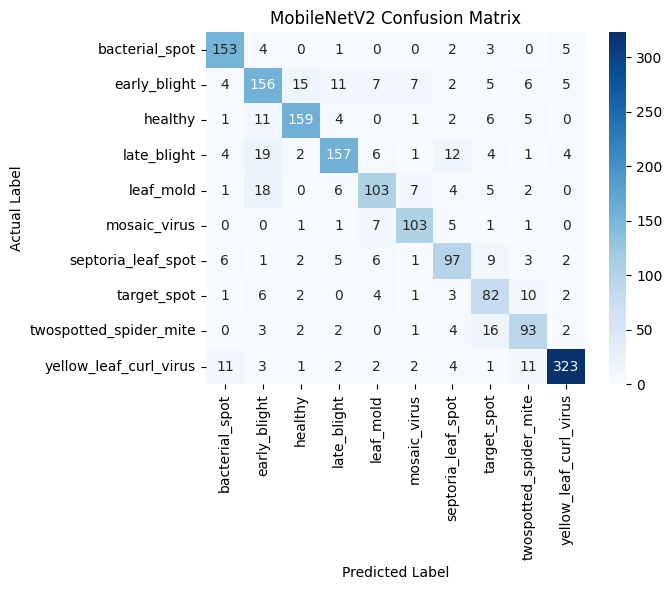


🚀 Training ResNet50
Epoch 1/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - accuracy: 0.5095 - loss: 1.5110 - val_accuracy: 0.8828 - val_loss: 0.4376
Epoch 2/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.8419 - loss: 0.4997 - val_accuracy: 0.9206 - val_loss: 0.2891
Epoch 3/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.8850 - loss: 0.3503 - val_accuracy: 0.9403 - val_loss: 0.2240
Epoch 4/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.9090 - loss: 0.2794 - val_accuracy: 0.9414 - val_loss: 0.1905
Epoch 5/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.9274 - loss: 0.2309 - val_accuracy: 0.9499 - val_loss: 0.1676
Epoch 6/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.9394 - loss: 0.1942 - val_accuracy: 0.9544 - val_loss: 0.1510
Epoch 7/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.9475 - loss: 0.1708 - val_accuracy: 0.9606 - val_loss: 0.1371
Epoch 8/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9

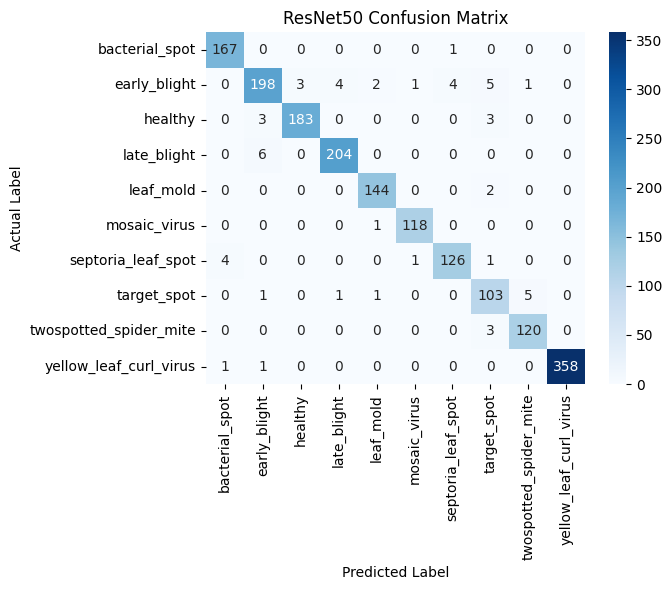


🚀 Training VGG16
Epoch 1/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 55s 104ms/step - accuracy: 0.2783 - loss: 3.9314 - val_accuracy: 0.6975 - val_loss: 0.9199
Epoch 2/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.5956 - loss: 1.2018 - val_accuracy: 0.7882 - val_loss: 0.6763
Epoch 3/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.6936 - loss: 0.8870 - val_accuracy: 0.8400 - val_loss: 0.5356
Epoch 4/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.7584 - loss: 0.7161 - val_accuracy: 0.8699 - val_loss: 0.4589
Epoch 5/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.7881 - loss: 0.6299 - val_accuracy: 0.8777 - val_loss: 0.4086
Epoch 6/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.8119 - loss: 0.5579 - val_accuracy: 0.8913 - val_loss: 0.3667
Epoch 7/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.8285 - loss: 0.4997 - val_accuracy: 0.8918 - val_loss: 0.3411
Epoch 8/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.842

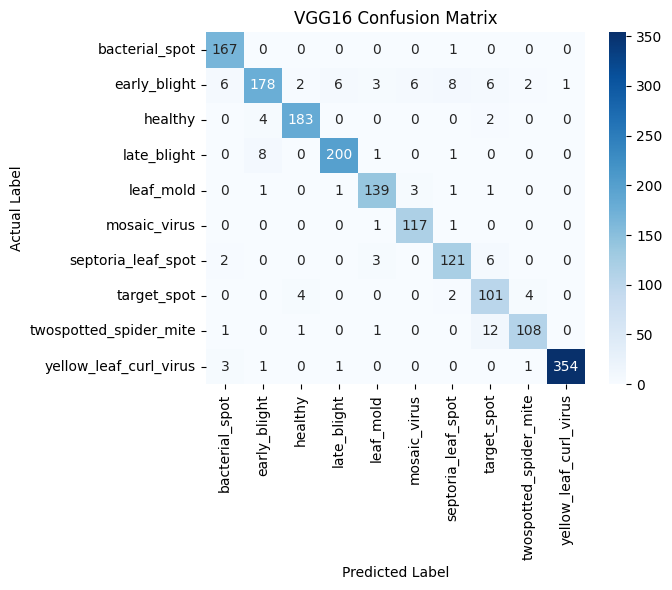


🚀 Training EfficientNetB0
Epoch 1/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.3882 - loss: 1.8013 - val_accuracy: 0.7211 - val_loss: 0.9072
Epoch 2/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6494 - loss: 1.0514 - val_accuracy: 0.7769 - val_loss: 0.7115
Epoch 3/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7124 - loss: 0.8584 - val_accuracy: 0.7994 - val_loss: 0.6136
Epoch 4/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7432 - loss: 0.7590 - val_accuracy: 0.8152 - val_loss: 0.5595
Epoch 5/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.7610 - loss: 0.6875 - val_accuracy: 0.8282 - val_loss: 0.5176
Epoch 6/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7774 - loss: 0.6444 - val_accuracy: 0.8383 - val_loss: 0.4828
Epoch 7/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.7965 - loss: 0.5999 - val_accuracy: 0.8451 - val_loss: 0.4612
Epoch 8/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accurac

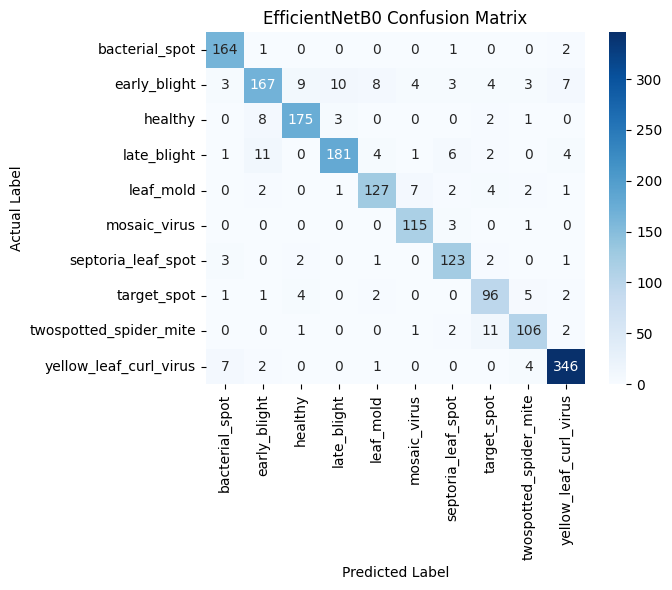


🚀 Training DenseNet121
Epoch 1/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 82s 127ms/step - accuracy: 0.3046 - loss: 3.5916 - val_accuracy: 0.6580 - val_loss: 1.0564
Epoch 2/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.5880 - loss: 1.2208 - val_accuracy: 0.7352 - val_loss: 0.8132
Epoch 3/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.6700 - loss: 0.9802 - val_accuracy: 0.7656 - val_loss: 0.6930
Epoch 4/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.7044 - loss: 0.8564 - val_accuracy: 0.7910 - val_loss: 0.6191
Epoch 5/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.7349 - loss: 0.7652 - val_accuracy: 0.8079 - val_loss: 0.5771
Epoch 6/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.7562 - loss: 0.6998 - val_accuracy: 0.8169 - val_loss: 0.5338
Epoch 7/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.7724 - loss: 0.6546 - val_accuracy: 0.8270 - val_loss: 0.4914
Epoch 8/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy:

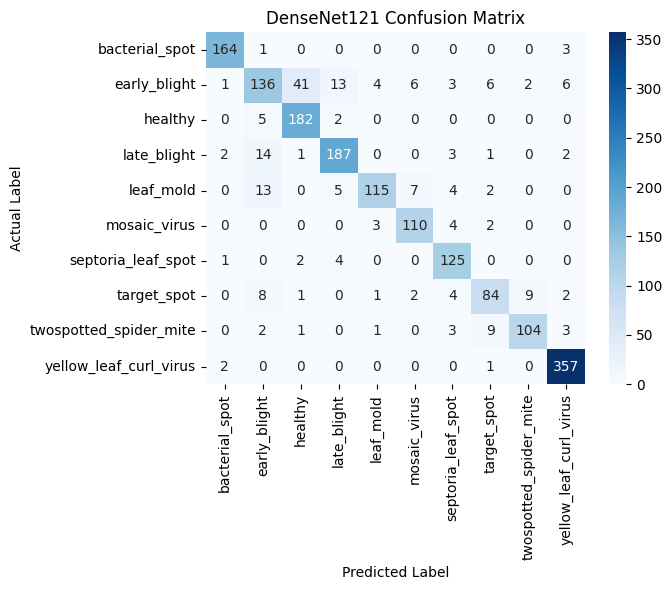


🚀 Training DenseNet169
Epoch 1/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 99s 154ms/step - accuracy: 0.3400 - loss: 4.5195 - val_accuracy: 0.6749 - val_loss: 0.9884
Epoch 2/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.5891 - loss: 1.2045 - val_accuracy: 0.7375 - val_loss: 0.7850
Epoch 3/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.6565 - loss: 0.9973 - val_accuracy: 0.7690 - val_loss: 0.6964
Epoch 4/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.6979 - loss: 0.8681 - val_accuracy: 0.7848 - val_loss: 0.6363
Epoch 5/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.7165 - loss: 0.7943 - val_accuracy: 0.7966 - val_loss: 0.5831
Epoch 6/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.7440 - loss: 0.7218 - val_accuracy: 0.8101 - val_loss: 0.5440
Epoch 7/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.7628 - loss: 0.6663 - val_accuracy: 0.8192 - val_loss: 0.5096
Epoch 8/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy:

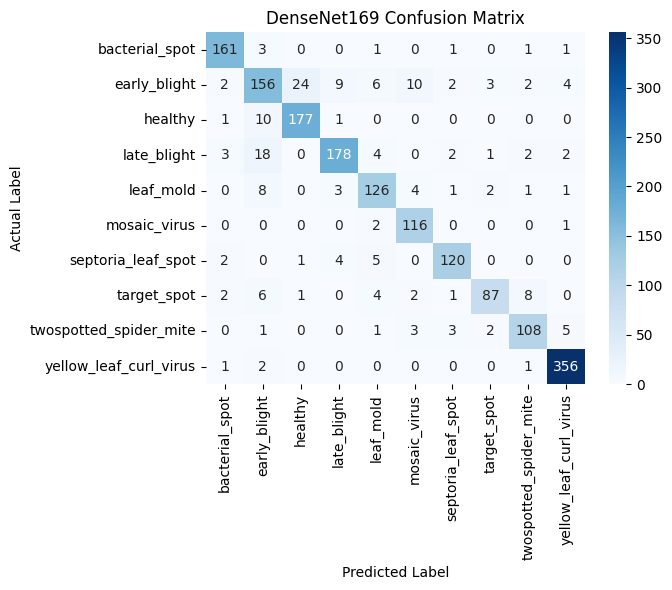


🚀 Training InceptionV3
Epoch 1/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 52s 87ms/step - accuracy: 0.2024 - loss: 8.2691 - val_accuracy: 0.3273 - val_loss: 1.9737
Epoch 2/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.2717 - loss: 2.0875 - val_accuracy: 0.3792 - val_loss: 1.7632
Epoch 3/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.3232 - loss: 1.9183 - val_accuracy: 0.4163 - val_loss: 1.6763
Epoch 4/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.3602 - loss: 1.8245 - val_accuracy: 0.4485 - val_loss: 1.6048
Epoch 5/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.3823 - loss: 1.7589 - val_accuracy: 0.4699 - val_loss: 1.5275
Epoch 6/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.4167 - loss: 1.6690 - val_accuracy: 0.4817 - val_loss: 1.4848
Epoch 7/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.4205 - loss: 1.6190 - val_accuracy: 0.4935 - val_loss: 1.4513
Epoch 8/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 

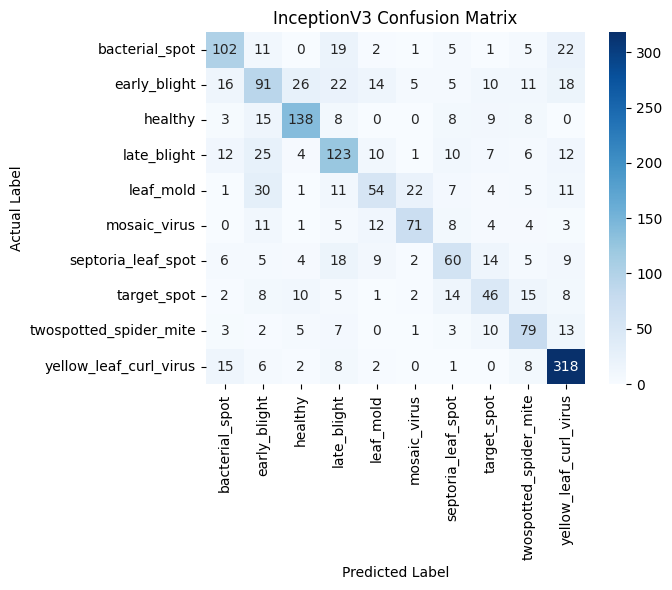


🚀 Training Xception
Epoch 1/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 54s 99ms/step - accuracy: 0.3014 - loss: 3.0093 - val_accuracy: 0.5752 - val_loss: 1.3064
Epoch 2/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.5107 - loss: 1.4663 - val_accuracy: 0.6163 - val_loss: 1.1445
Epoch 3/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.5683 - loss: 1.2623 - val_accuracy: 0.6501 - val_loss: 1.0427
Epoch 4/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.6002 - loss: 1.1557 - val_accuracy: 0.6710 - val_loss: 0.9752
Epoch 5/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.6334 - loss: 1.0548 - val_accuracy: 0.6789 - val_loss: 0.9151
Epoch 6/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.6524 - loss: 0.9922 - val_accuracy: 0.6975 - val_loss: 0.8815
Epoch 7/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.6711 - loss: 0.9382 - val_accuracy: 0.7155 - val_loss: 0.8377
Epoch 8/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.6

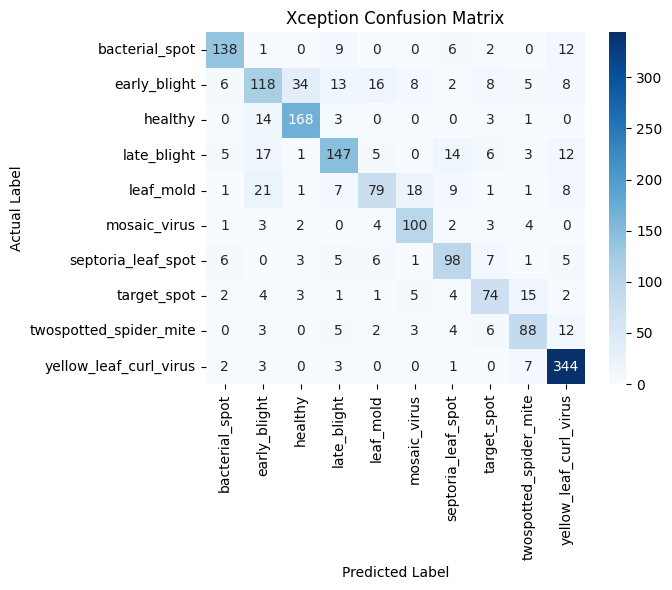


🚀 Training NASNetMobile
Epoch 1/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 79s 115ms/step - accuracy: 0.1849 - loss: 4.2848 - val_accuracy: 0.4276 - val_loss: 1.7101
Epoch 2/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.3287 - loss: 2.1489 - val_accuracy: 0.4586 - val_loss: 1.6025
Epoch 3/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.4015 - loss: 1.7940 - val_accuracy: 0.4766 - val_loss: 1.5301
Epoch 4/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.4308 - loss: 1.6708 - val_accuracy: 0.4946 - val_loss: 1.4796
Epoch 5/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.4473 - loss: 1.6026 - val_accuracy: 0.5104 - val_loss: 1.4413
Epoch 6/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.4706 - loss: 1.5459 - val_accuracy: 0.5127 - val_loss: 1.4084
Epoch 7/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.4769 - loss: 1.5016 - val_accuracy: 0.5262 - val_loss: 1.3814
Epoch 8/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy

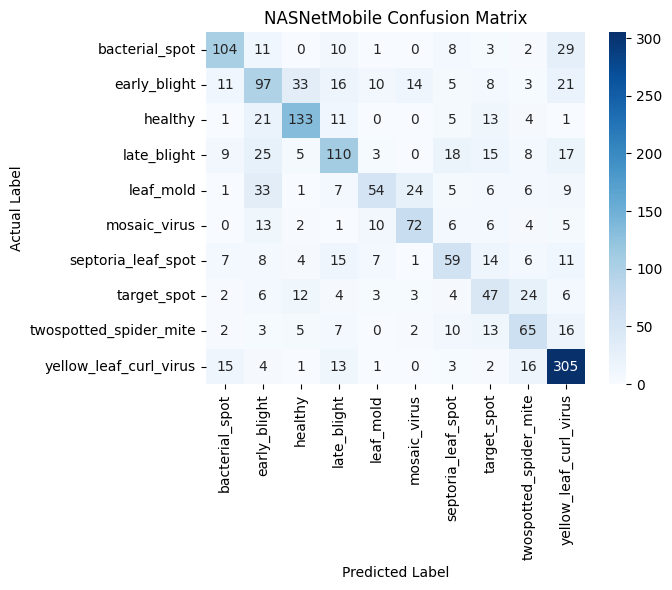


 Best Model: ResNet50
Best model 'ResNet50' saved as 'best_model.keras' done

Per-class F1 for ResNet50:
bacterial_spot      : 0.9824
early_blight        : 0.9274
healthy             : 0.9760
late_blight         : 0.9737
leaf_mold           : 0.9796
mosaic_virus        : 0.9874
septoria_leaf_spot  : 0.9582
target_spot         : 0.9035
twospotted_spider_mite: 0.9639
yellow_leaf_curl_virus: 0.9972
Class names saved as 'class_names.pkl' done


In [13]:
# 9. TRAIN ALL MODELS AND SAVE BEST

models, results, models_history = {}, [], {}  # add models_history dict

for name, base in cnn_models.items():
    model, metrics = train_and_evaluate(name, base)
    models[name] = model              # store trained model
    results.append(metrics)           # store metrics
    models_history[name] = metrics["history"]  # store training history

# Collect per-class F1
f1_dict = {}
for res in results:
    f1_dict[res["model"]] = res["f1_per_class"]

# Convert metrics to DataFrame
df = pd.DataFrame(results)
# Save all metrics
import pandas as pd
df.to_csv("all_model_metrics.csv", index=False)

# Select best model by F1
best = df.sort_values("f1_macro", ascending=False).iloc[0]
best_name = best["model"]
print("\n Best Model:", best_name)

# Save best model
models[best_name].save("best_model.keras")
print(f"Best model '{best_name}' saved as 'best_model.keras' done")

#Print per-class F1 for Best Model
import numpy as np
print(f"\nPer-class F1 for {best_name}:")
for cls, f1 in zip(class_names, f1_dict[best_name]):
    print(f"{cls:20s}: {f1:.4f}")
    
# Save class names
import pickle
with open("class_names.pkl", "wb") as f:
    pickle.dump(class_names, f)
print("Class names saved as 'class_names.pkl' done")

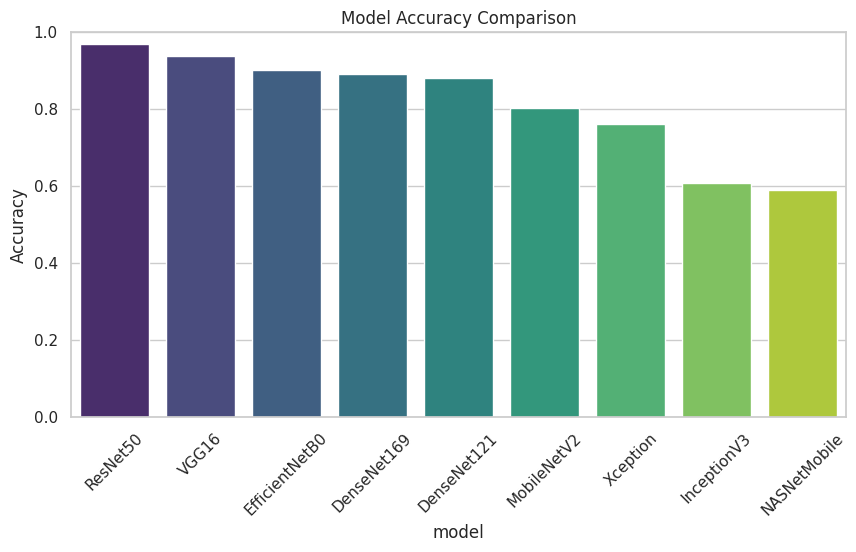

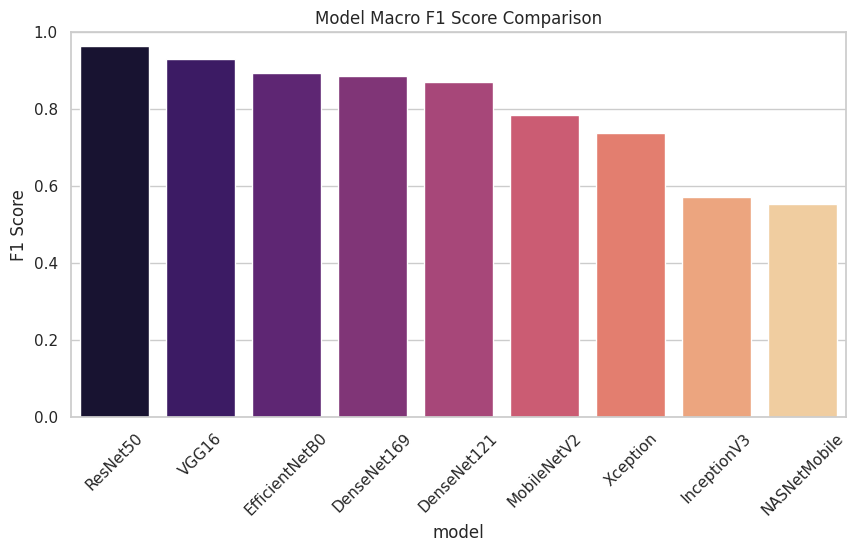

In [14]:
# Bar Plot Comparison
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# Accuracy comparison
plt.figure(figsize=(10,5))
sns.barplot(
    x="model",
    y="accuracy",
    data=df.sort_values("accuracy", ascending=False),
    palette="viridis"
)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

# F1 score comparison
plt.figure(figsize=(10,5))
sns.barplot(
    x="model",
    y="f1_macro",
    data=df.sort_values("f1_macro", ascending=False),
    palette="magma"
)
plt.title("Model Macro F1 Score Comparison")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


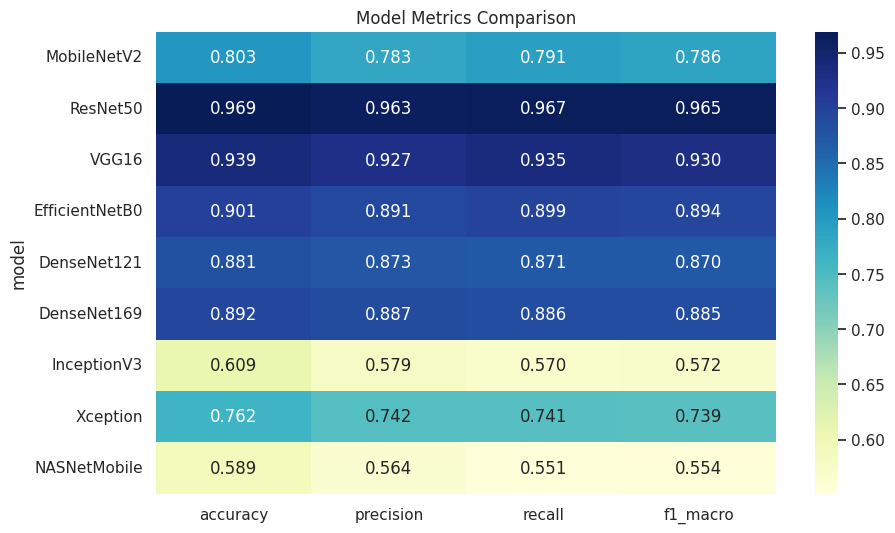

In [15]:
# Set model names as index
df_metrics = df.set_index("model")[["accuracy","precision","recall","f1_macro"]]

plt.figure(figsize=(10,6))
sns.heatmap(df_metrics, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Model Metrics Comparison")
plt.show()


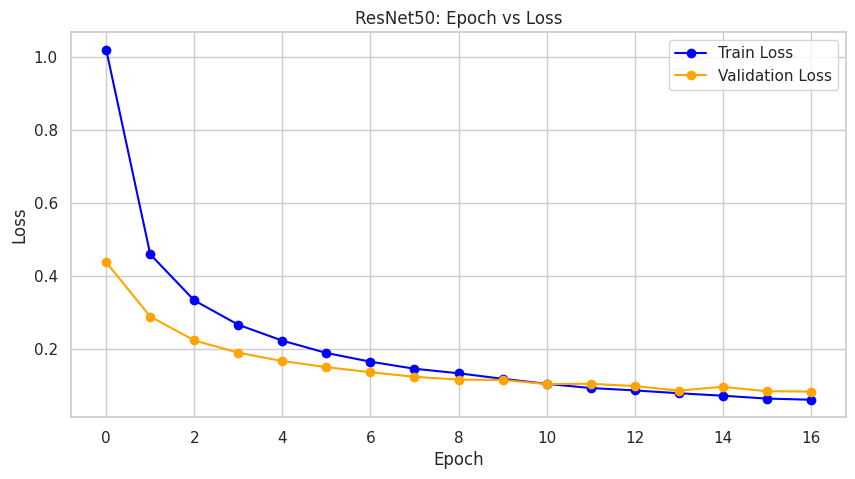

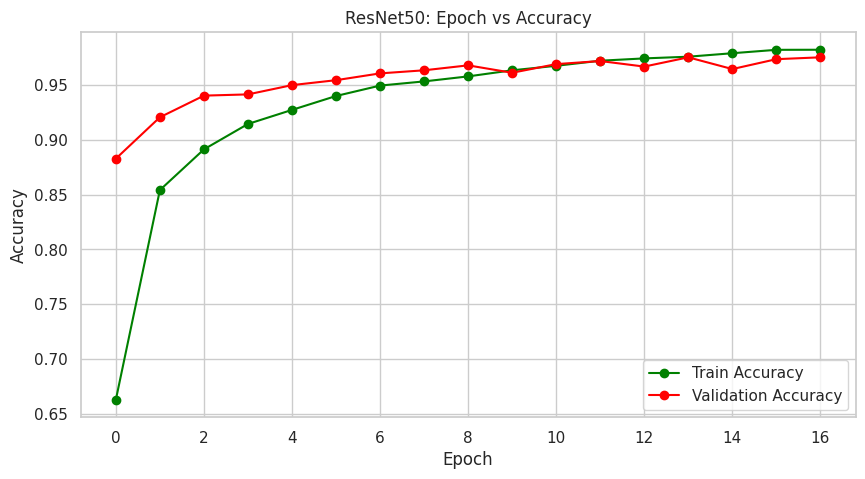

In [16]:
#Plot Epoch vs Loss / Accuracy

import matplotlib.pyplot as plt

# Training & Validation Loss
history = models_history["ResNet50"]

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title("ResNet50: Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Training & Validation Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
plt.title("ResNet50: Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import json

with open("class_names.json", "w") as f:
    json.dump(class_names, f, indent=4)

print("✅ Class names saved as class_names.json")

✅ Class names saved as class_names.json


In [18]:
#Plot Epoch vs Loss
import matplotlib.pyplot as plt

def plot_loss(history, model_name):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Epoch vs Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



🚀 Training ResNet50
Epoch 1/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.5109 - loss: 1.4933 - val_accuracy: 0.8800 - val_loss: 0.4351
Epoch 2/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.8300 - loss: 0.5143 - val_accuracy: 0.9149 - val_loss: 0.2972
Epoch 3/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.8837 - loss: 0.3612 - val_accuracy: 0.9318 - val_loss: 0.2343
Epoch 4/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9021 - loss: 0.2906 - val_accuracy: 0.9369 - val_loss: 0.1981
Epoch 5/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9313 - loss: 0.2264 - val_accuracy: 0.9504 - val_loss: 0.1715
Epoch 6/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9382 - loss: 0.1981 - val_accuracy: 0.9532 - val_loss: 0.1495
Epoch 7/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9452 - loss: 0.1671 - val_accuracy: 0.9572 - val_loss: 0.1450
Epoch 8/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9

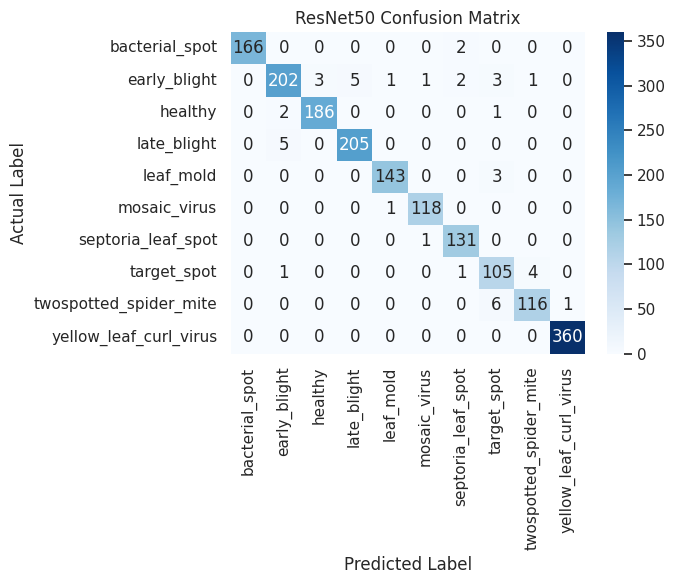

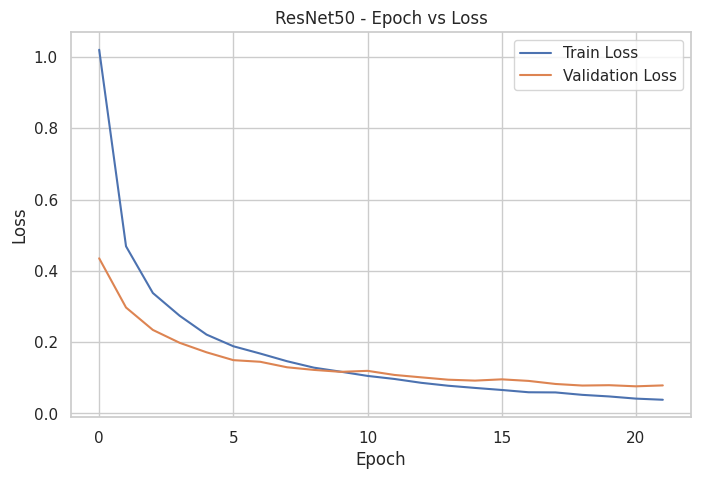

In [19]:
model, metrics = train_and_evaluate("ResNet50", cnn_models["ResNet50"])
plot_loss(metrics["history"], "ResNet50")


In [20]:
#Multi-Model Loss Comparison
def plot_multi_model_loss(histories, model_names):
    plt.figure(figsize=(10,6))
    for hist, name in zip(histories, model_names):
        plt.plot(hist.history['val_loss'], label=f'{name} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()


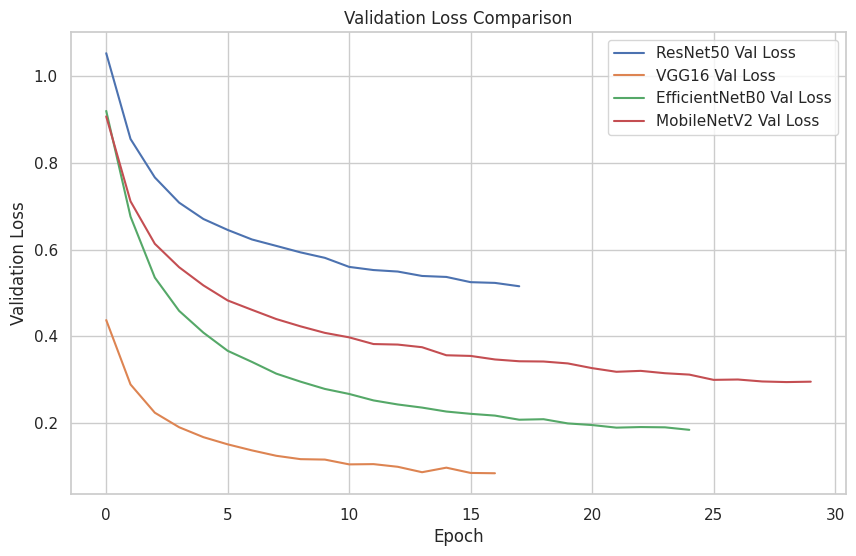

In [21]:

model_names = ["ResNet50", "VGG16", "EfficientNetB0", "MobileNetV2"]

# Collect histories from results
histories = [metrics["history"] for metrics in results if metrics["model"] in model_names]

# Plot multi-model loss
plot_multi_model_loss(histories, model_names)



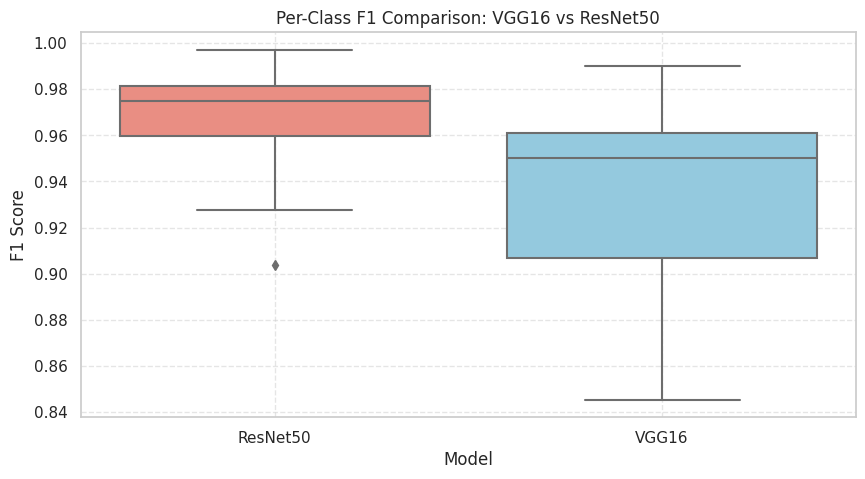

Paired t-test VGG16 vs ResNet50: t=-5.306, p=0.000
Wilcoxon signed-rank test VGG16 vs ResNet50: W=0.000, p=0.002


In [22]:
# -----------------------------
# Statistical Comparison: VGG16 vs ResNet50
# -----------------------------

# Use metrics from already trained models
all_metrics_list = results  # results from training loop

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon

# Build per-class F1 DataFrame
f1_df_list = []
for metrics in all_metrics_list:
    if metrics['model'] in ["VGG16","ResNet50"]:  # only these two
        for cls, f1 in zip(class_names, metrics['f1_per_class']):
            f1_df_list.append({"Model": metrics['model'], "Class": cls, "F1": f1})

f1_df = pd.DataFrame(f1_df_list)

# Optional: Save per-class F1 to CSV
f1_df.to_csv("vgg16_resnet50_f1_per_class.csv", index=False)

# Boxplot per-class F1
plt.figure(figsize=(10,5))
sns.boxplot(
    x='Model',
    y='F1',
    data=f1_df,
    palette=["salmon","skyblue"]
)
plt.title("Per-Class F1 Comparison: VGG16 vs ResNet50")
plt.ylabel("F1 Score")
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# -----------------------------
# Paired t-test & Wilcoxon test
# -----------------------------
vgg16_f1 = f1_df[f1_df['Model']=="VGG16"]['F1'].values
resnet_f1 = f1_df[f1_df['Model']=="ResNet50"]['F1'].values

# Paired t-test
t_stat, p_val = ttest_rel(vgg16_f1, resnet_f1)
print(f"Paired t-test VGG16 vs ResNet50: t={t_stat:.3f}, p={p_val:.3f}")

# Wilcoxon signed-rank test
w_stat, p_wil = wilcoxon(vgg16_f1, resnet_f1)
print(f"Wilcoxon signed-rank test VGG16 vs ResNet50: W={w_stat:.3f}, p={p_wil:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


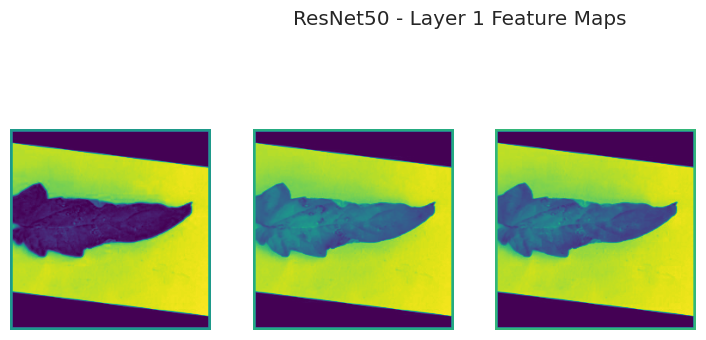

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


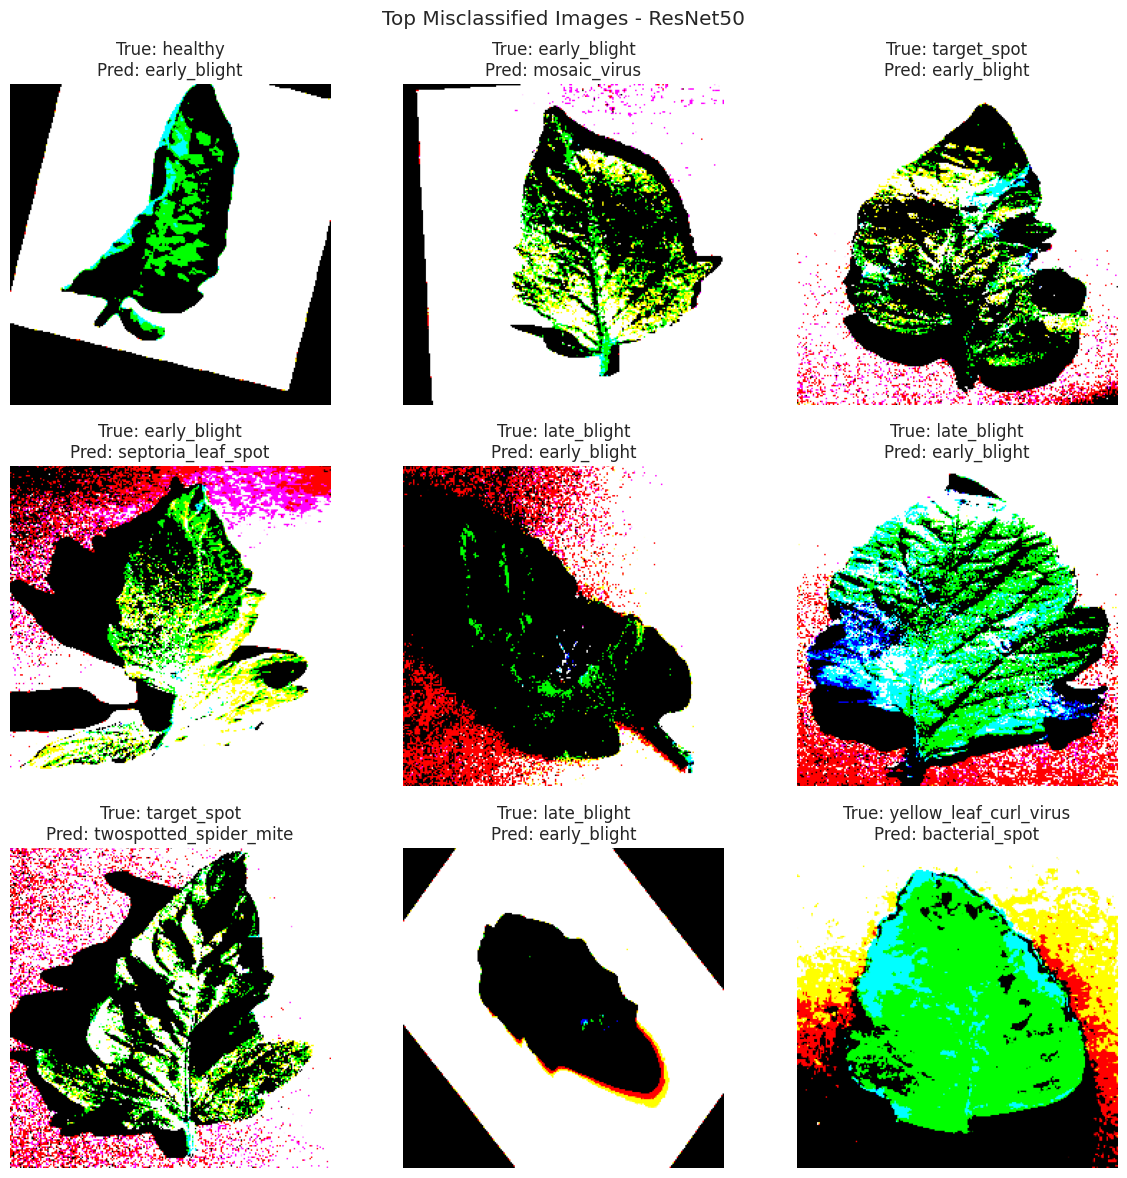

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
ResNet50: Parameters=24.11M, Inference Time=1515.55 ms


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

test_images = []
test_labels = []

for X_batch, y_batch in test_ds:
    test_images.append(X_batch.numpy())
    test_labels.append(y_batch.numpy())

test_images = np.vstack(test_images)
test_labels = np.vstack(test_labels)

y_true = np.argmax(test_labels, axis=1)

# -----------------------------
#  Extract metrics for ResNet50
# -----------------------------
resnet_metrics = None
for m in all_metrics_list:
    if m["model"] == "ResNet50":
        resnet_metrics = m
        break

if resnet_metrics is None:
    raise ValueError("ResNet50 metrics not found. Make sure it is trained and stored in all_metrics_list.")

y_true = resnet_metrics["y_true"]
y_pred = resnet_metrics["y_pred"]

# -----------------------------
# Layer-wise Feature Maps
# -----------------------------
import tensorflow as tf

# Select ResNet50 model
resnet_model = models["ResNet50"]

# Pick a test image
img = test_images[0]  # shape: (IMG_SIZE, IMG_SIZE, 3)
img_input = np.expand_dims(img, axis=0)

# Get all convolutional layer outputs
conv_layers = [layer.output for layer in resnet_model.layers if 'conv' in layer.name]
activation_model = tf.keras.models.Model(inputs=resnet_model.input, outputs=conv_layers)

activations = activation_model.predict(img_input)

# Plot first conv layer activations
first_layer_activation = activations[0]
plt.figure(figsize=(12,12))
for i in range(min(16, first_layer_activation.shape[-1])):
    plt.subplot(4,4,i+1)
    plt.imshow(first_layer_activation[0,:,:,i], cmap='viridis')
    plt.axis('off')
plt.suptitle("ResNet50 - Layer 1 Feature Maps")
plt.show()

# -----------------------------
# Top Misclassified Images
# -----------------------------
mis_idx = [i for i,(yt, yp) in enumerate(zip(y_true, y_pred)) if yt != yp]

plt.figure(figsize=(12,12))
for i, idx in enumerate(mis_idx[:9]):  # show top 9
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[idx])
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
    plt.axis('off')
plt.suptitle("Top Misclassified Images - ResNet50")
plt.tight_layout()
plt.show()

# -----------------------------
# Efficiency / Inference Time
# -----------------------------
params = resnet_model.count_params()
sample_input = np.expand_dims(test_images[0], axis=0)

start = time.time()
_ = resnet_model.predict(sample_input)
end = time.time()
inference_time = (end - start) * 1000  # ms

print(f"ResNet50: Parameters={params/1e6:.2f}M, Inference Time={inference_time:.2f} ms")


In [24]:
# Per-Class Accuracy (Class-wise Accuracy)
# ----------------------------
# 1️Get metrics for ResNet50
# ----------------------------
resnet_metrics = None
for m in results:   # results already contains metrics for all models
    if m["model"] == "ResNet50":
        resnet_metrics = m
        break

if resnet_metrics is None:
    raise ValueError("ResNet50 metrics not found in results.")

y_true = resnet_metrics["y_true"]
y_pred = resnet_metrics["y_pred"]

# ----------------------------
#  Compute per-class accuracy
# ----------------------------
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("\nPer-Class Accuracy:")
for cls, acc in zip(class_names, per_class_acc):
    print(f"{cls:20s}: {acc*100:.2f}%")



Per-Class Accuracy:
bacterial_spot      : 99.40%
early_blight        : 90.83%
healthy             : 96.83%
late_blight         : 97.14%
leaf_mold           : 98.63%
mosaic_virus        : 99.16%
septoria_leaf_spot  : 95.45%
target_spot         : 92.79%
twospotted_spider_mite: 97.56%
yellow_leaf_curl_virus: 99.44%


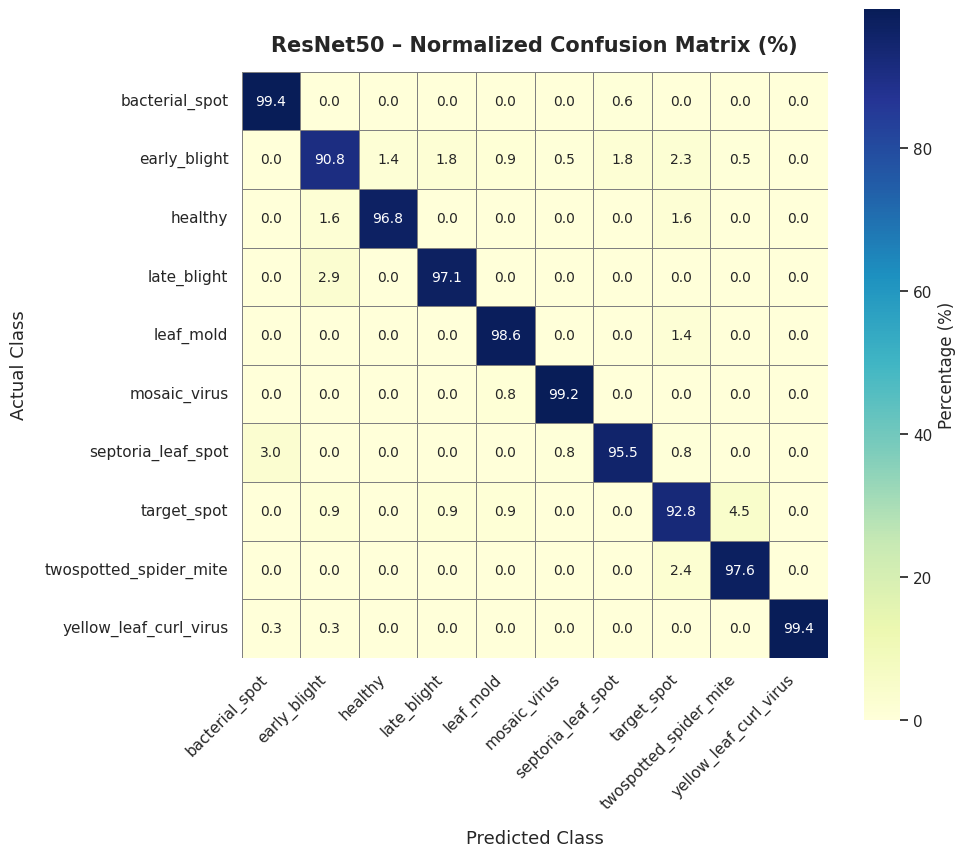

In [25]:
# Normalized Confusion Matrix (%)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# ----------------------------
# Get ResNet50 metrics
# ----------------------------
model_name = "ResNet50"
resnet_metrics = next(m for m in results if m["model"] == model_name)

y_true = resnet_metrics["y_true"]
y_pred = resnet_metrics["y_pred"]

# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# ----------------------------
# Plot (Class names shown)
# ----------------------------
plt.figure(figsize=(10,9))

ax = sns.heatmap(
    cm_norm * 100,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    square=True,
    linewidths=0.7,
    linecolor="gray",
    cbar_kws={"label": "Percentage (%)"},
    annot_kws={"size":10}
)

# Set class names explicitly
ax.set_xticks(np.arange(len(class_names)) + 0.5)
ax.set_yticks(np.arange(len(class_names)) + 0.5)

ax.set_xticklabels(class_names, rotation=45, ha="right", fontsize=11)
ax.set_yticklabels(class_names, rotation=0, fontsize=11)

ax.set_xlabel("Predicted Class", fontsize=13, labelpad=12)
ax.set_ylabel("Actual Class", fontsize=13, labelpad=12)

ax.set_title(
    "ResNet50 – Normalized Confusion Matrix (%)",
    fontsize=15,
    weight="bold",
    pad=15
)

plt.tight_layout()
plt.savefig("ResNet50_Normalized_Confusion_Matrix_ClassNames.png", dpi=300)
plt.show()


In [26]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

# ----------------------------
# Get metrics for ResNet50
# ----------------------------
model_name = "ResNet50"
resnet_metrics = None
for m in results:   # results contains metrics for all trained models
    if m["model"] == model_name:
        resnet_metrics = m
        break

if resnet_metrics is None:
    raise ValueError(f"{model_name} metrics not found in results.")

y_true = resnet_metrics["y_true"]
y_pred = resnet_metrics["y_pred"]

# ----------------------------
# Class-wise Precision & Recall
# ----------------------------
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)

# ----------------------------
# Print results
# ----------------------------
print(f"\n{model_name} → Class-wise Precision & Recall:")
for cls, p, r in zip(class_names, precision_per_class, recall_per_class):
    print(f"{cls:20s} → Precision: {p*100:.2f}%, Recall: {r*100:.2f}%")




ResNet50 → Class-wise Precision & Recall:
bacterial_spot       → Precision: 97.09%, Recall: 99.40%
early_blight         → Precision: 94.74%, Recall: 90.83%
healthy              → Precision: 98.39%, Recall: 96.83%
late_blight          → Precision: 97.61%, Recall: 97.14%
leaf_mold            → Precision: 97.30%, Recall: 98.63%
mosaic_virus         → Precision: 98.33%, Recall: 99.16%
septoria_leaf_spot   → Precision: 96.18%, Recall: 95.45%
target_spot          → Precision: 88.03%, Recall: 92.79%
twospotted_spider_mite → Precision: 95.24%, Recall: 97.56%
yellow_leaf_curl_virus → Precision: 100.00%, Recall: 99.44%


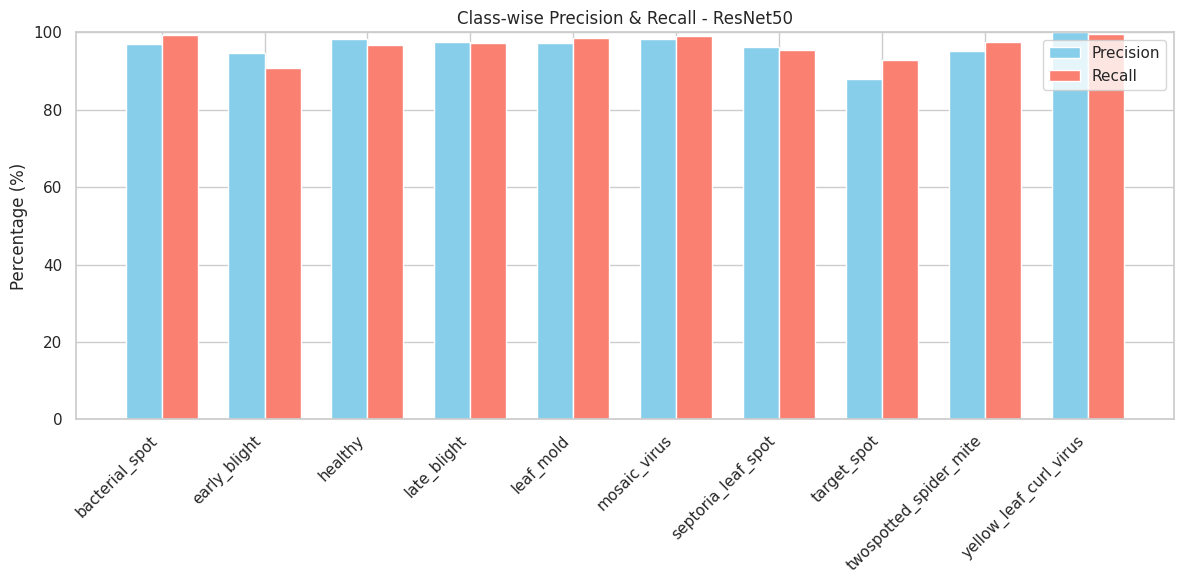

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Get metrics for ResNet50
model_name = "ResNet50"
resnet_metrics = None
for m in results:
    if m["model"] == model_name:
        resnet_metrics = m
        break

if resnet_metrics is None:
    raise ValueError(f"{model_name} metrics not found in results.")

precision_per_class = precision_score(resnet_metrics["y_true"], resnet_metrics["y_pred"], average=None)
recall_per_class = recall_score(resnet_metrics["y_true"], resnet_metrics["y_pred"], average=None)

# Bar chart
x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, precision_per_class*100, width, label='Precision', color='skyblue')
plt.bar(x + width/2, recall_per_class*100, width, label='Recall', color='salmon')

plt.xticks(x, class_names, rotation=45, ha="right")
plt.ylabel("Percentage (%)")
plt.title(f"Class-wise Precision & Recall - {model_name}")
plt.legend()
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


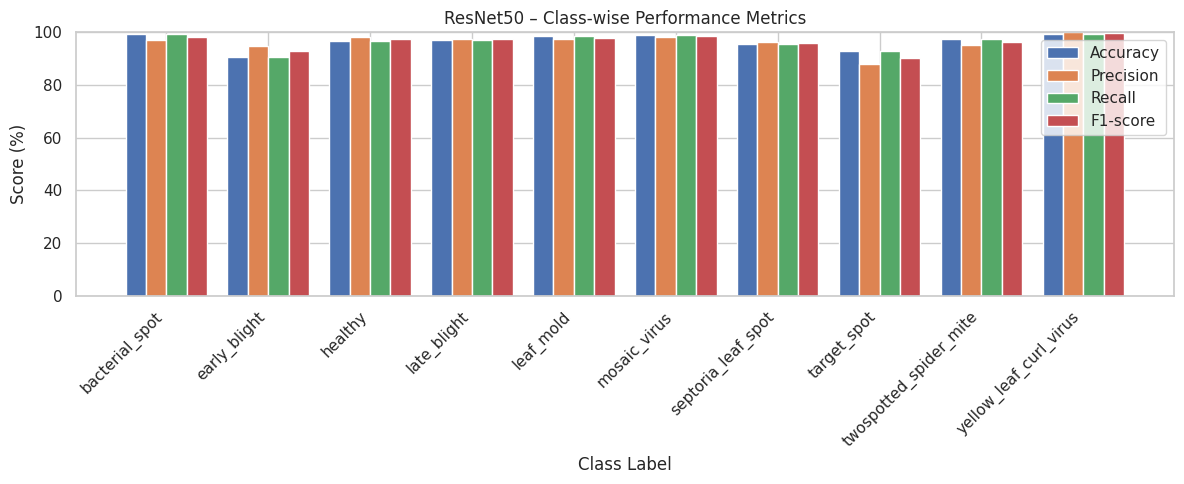

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# ----------------------------
# Get metrics for ResNet50
# ----------------------------
model_name = "ResNet50"
resnet_metrics = None
for m in results:
    if m["model"] == model_name:
        resnet_metrics = m
        break

if resnet_metrics is None:
    raise ValueError(f"{model_name} metrics not found in results.")

y_true = resnet_metrics["y_true"]
y_pred = resnet_metrics["y_pred"]

# ----------------------------
# Compute per-class metrics
# ----------------------------
cm = confusion_matrix(y_true, y_pred)
acc_per_class = cm.diagonal() / cm.sum(axis=1)
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

# ----------------------------
# Plot
# ----------------------------
x = np.arange(len(class_names))
width = 0.2

plt.figure(figsize=(12,5))
plt.bar(x - 1.5*width, acc_per_class*100, width, label="Accuracy")
plt.bar(x - 0.5*width, precision_per_class*100, width, label="Precision")
plt.bar(x + 0.5*width, recall_per_class*100, width, label="Recall")
plt.bar(x + 1.5*width, f1_per_class*100, width, label="F1-score")

plt.xticks(x, class_names, rotation=45, ha="right")
plt.ylabel("Score (%)")
plt.xlabel("Class Label")
plt.title(f"{model_name} – Class-wise Performance Metrics")
plt.legend()
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


# Final Model Train

In [29]:
FINAL_EPOCHS = 11

final_model = build_model(cnn_models["ResNet50"], trainable=False)

final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINAL_EPOCHS,
    verbose=1
)

final_model.save("ResNet50_final_8epochs.keras")

final_model.save("best_model.h5")


Epoch 1/11
444/444 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.5089 - loss: 1.4855 - val_accuracy: 0.8862 - val_loss: 0.4389
Epoch 2/11
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.8288 - loss: 0.5327 - val_accuracy: 0.9104 - val_loss: 0.3002
Epoch 3/11
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.8840 - loss: 0.3600 - val_accuracy: 0.9363 - val_loss: 0.2219
Epoch 4/11
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9100 - loss: 0.2797 - val_accuracy: 0.9420 - val_loss: 0.1938
Epoch 5/11
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9281 - loss: 0.2315 - val_accuracy: 0.9527 - val_loss: 0.1618
Epoch 6/11
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9373 - loss: 0.2020 - val_accuracy: 0.9561 - val_loss: 0.1466
Epoch 7/11
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9468 - loss: 0.1722 - val_accuracy: 0.9600 - val_loss: 0.1333
Epoch 8/11
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9545 - loss: 0.1511 - 

In [30]:
#Training + Best Model Save (keras & h5)

from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# ---- Checkpoints ----
checkpoint_keras = ModelCheckpoint(
    filepath="best_model2.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

checkpoint_h5 = ModelCheckpoint(
    filepath="best_model2.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

FINAL_EPOCHS = 30

final_model = build_model(
    cnn_models["ResNet50"],
    trainable=False
)

history = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINAL_EPOCHS,
    callbacks=[checkpoint_keras, checkpoint_h5],
    verbose=1
)



Epoch 1/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5106 - loss: 1.4773
Epoch 1: val_accuracy improved from -inf to 0.88451, saving model to best_model2.keras

Epoch 1: val_accuracy improved from -inf to 0.88451, saving model to best_model2.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.5109 - loss: 1.4763 - val_accuracy: 0.8845 - val_loss: 0.4279
Epoch 2/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8380 - loss: 0.4968
Epoch 2: val_accuracy improved from 0.88451 to 0.91380, saving model to best_model2.keras

Epoch 2: val_accuracy improved from 0.88451 to 0.91380, saving model to best_model2.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.8381 - loss: 0.4967 - val_accuracy: 0.9138 - val_loss: 0.2890
Epoch 3/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8828 - loss: 0.3550
Epoch 3: val_accuracy improved from 0.91380 to 0.93972, saving model to best_model2.keras

Epoch 3: val_accuracy improved from 0.91380 to 0.93972, saving model to best_model2.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.8828 - loss: 0.3549 - val_accuracy: 0.9397 - val_loss: 0.2220
Epoch 4/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9125 - loss: 0.2793
Epoch 4: val_accuracy improved from 0.93972 to 0.94592, saving model to best_model2.keras

Epoch 4: val_accuracy improved from 0.93972 to 0.94592, saving model to best_model2.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9126 - loss: 0.2793 - val_accuracy: 0.9459 - val_loss: 0.1893
Epoch 5/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.2291
Epoch 5: val_accuracy improved from 0.94592 to 0.95606, saving model to best_model2.keras

Epoch 5: val_accuracy improved from 0.94592 to 0.95606, saving model to best_model2.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9313 - loss: 0.2291 - val_accuracy: 0.9561 - val_loss: 0.1667
Epoch 6/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9393 - loss: 0.1928
Epoch 6: val_accuracy improved from 0.95606 to 0.95718, saving model to best_model2.keras

Epoch 6: val_accuracy improved from 0.95606 to 0.95718, saving model to best_model2.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9393 - loss: 0.1927 - val_accuracy: 0.9572 - val_loss: 0.1515
Epoch 7/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9473 - loss: 0.1691
Epoch 7: val_accuracy improved from 0.95718 to 0.96169, saving model to best_model2.keras

Epoch 7: val_accuracy improved from 0.95718 to 0.96169, saving model to best_model2.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9473 - loss: 0.1690 - val_accuracy: 0.9617 - val_loss: 0.1331
Epoch 8/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9544 - loss: 0.1469
Epoch 8: val_accuracy improved from 0.96169 to 0.96338, saving model to best_model2.keras

Epoch 8: val_accuracy improved from 0.96169 to 0.96338, saving model to best_model2.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9544 - loss: 0.1469 - val_accuracy: 0.9634 - val_loss: 0.1256
Epoch 9/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9589 - loss: 0.1318
Epoch 9: val_accuracy did not improve from 0.96338

Epoch 9: val_accuracy did not improve from 0.96338
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9589 - loss: 0.1318 - val_accuracy: 0.9600 - val_loss: 0.1210
Epoch 10/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9606 - loss: 0.1235
Epoch 10: val_accuracy improved from 0.96338 to 0.96732, saving model to best_model2.keras

Epoch 10: val_accuracy improved from 0.96338 to 0.96732, saving model to best_model2.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9606 - loss: 0.1235 - val_accuracy: 0.9673 - val_loss: 0.1146
Epoch 11/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9671 - loss: 0.1057
Epoch 11: val_accuracy did not improve from 0.96732

Epoch 11: val_accuracy did not improve from 0.96732
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9671 - loss: 0.1057 - val_accuracy: 0.9628 - val_loss: 0.1122
Epoch 12/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9705 - loss: 0.0960
Epoch 12: val_accuracy did not improve from 0.96732

Epoch 12: val_accuracy did not improve from 0.96732
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9705 - loss: 0.0959 - val_accuracy: 0.9639 - val_loss: 0.1038
Epoch 13/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9762 - loss: 0.0810
Epoch 13: val_accuracy did not improve from 0.96732

Epoch 13: val_accuracy did not improve from 0.96732
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9762 - 

444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9764 - loss: 0.0800 - val_accuracy: 0.9735 - val_loss: 0.0965
Epoch 15/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9790 - loss: 0.0727
Epoch 15: val_accuracy did not improve from 0.97352

Epoch 15: val_accuracy did not improve from 0.97352
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9790 - loss: 0.0727 - val_accuracy: 0.9713 - val_loss: 0.0909
Epoch 16/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9822 - loss: 0.0633
Epoch 16: val_accuracy did not improve from 0.97352

Epoch 16: val_accuracy did not improve from 0.97352
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9822 - loss: 0.0633 - val_accuracy: 0.9662 - val_loss: 0.0952
Epoch 17/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9834 - loss: 0.0572
Epoch 17: val_accuracy improved from 0.97352 to 0.97746, saving model to best_model2.keras

Epoch 17: val_accuracy improved from 0.97352 to 0.97746, saving model to best

444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9834 - loss: 0.0572 - val_accuracy: 0.9775 - val_loss: 0.0814
Epoch 18/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9856 - loss: 0.0542
Epoch 18: val_accuracy did not improve from 0.97746

Epoch 18: val_accuracy did not improve from 0.97746
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9856 - loss: 0.0542 - val_accuracy: 0.9713 - val_loss: 0.0871
Epoch 19/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9839 - loss: 0.0539
Epoch 19: val_accuracy did not improve from 0.97746

Epoch 19: val_accuracy did not improve from 0.97746
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9839 - loss: 0.0539 - val_accuracy: 0.9707 - val_loss: 0.0836
Epoch 20/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9854 - loss: 0.0509
Epoch 20: val_accuracy did not improve from 0.97746

Epoch 20: val_accuracy did not improve from 0.97746
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9854 - 

444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9914 - loss: 0.0362 - val_accuracy: 0.9786 - val_loss: 0.0707
Epoch 25/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9892 - loss: 0.0372
Epoch 25: val_accuracy did not improve from 0.97859

Epoch 25: val_accuracy did not improve from 0.97859
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9892 - loss: 0.0372 - val_accuracy: 0.9786 - val_loss: 0.0711
Epoch 26/30
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9929 - loss: 0.0306
Epoch 26: val_accuracy improved from 0.97859 to 0.97972, saving model to best_model2.keras

Epoch 26: val_accuracy improved from 0.97859 to 0.97972, saving model to best_model2.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9929 - loss: 0.0306 - val_accuracy: 0.9797 - val_loss: 0.0730
Epoch 27/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9922 - loss: 0.0304
Epoch 27: val_accuracy did not improve from 0.97972

Epoch 27: val_accuracy did not improve from 0.97972
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9922 - loss: 0.0304 - val_accuracy: 0.9758 - val_loss: 0.0714
Epoch 28/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9937 - loss: 0.0297
Epoch 28: val_accuracy did not improve from 0.97972

Epoch 28: val_accuracy did not improve from 0.97972
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9936 - loss: 0.0297 - val_accuracy: 0.9775 - val_loss: 0.0713
Epoch 29/30
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9951 - loss: 0.0248
Epoch 29: val_accuracy did not improve from 0.97972

Epoch 29: val_accuracy did not improve from 0.97972
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9951 - 

444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9952 - loss: 0.0228 - val_accuracy: 0.9808 - val_loss: 0.0682


In [31]:
#Epoch vs Accuracy & Loss PRINT

print("\nEpoch-wise Training Report")
print("-" * 55)

for i in range(len(history.history["accuracy"])):
    print(
        f"Epoch {i+1:02d} | "
        f"Train Acc: {history.history['accuracy'][i]:.4f} | "
        f"Val Acc: {history.history['val_accuracy'][i]:.4f} | "
        f"Train Loss: {history.history['loss'][i]:.4f} | "
        f"Val Loss: {history.history['val_loss'][i]:.4f}"
    )

# ---- Best epoch info ----
best_epoch = history.history["val_accuracy"].index(
    max(history.history["val_accuracy"])
) + 1

print("\nBest Epoch Summary")
print("-" * 30)
print(f"Best Epoch       : {best_epoch}")
print(f"Best Val Accuracy: {max(history.history['val_accuracy']):.4f}")



Epoch-wise Training Report
-------------------------------------------------------
Epoch 01 | Train Acc: 0.6656 | Val Acc: 0.8845 | Train Loss: 1.0037 | Val Loss: 0.4279
Epoch 02 | Train Acc: 0.8514 | Val Acc: 0.9138 | Train Loss: 0.4597 | Val Loss: 0.2890
Epoch 03 | Train Acc: 0.8933 | Val Acc: 0.9397 | Train Loss: 0.3321 | Val Loss: 0.2220
Epoch 04 | Train Acc: 0.9175 | Val Acc: 0.9459 | Train Loss: 0.2604 | Val Loss: 0.1893
Epoch 05 | Train Acc: 0.9309 | Val Acc: 0.9561 | Train Loss: 0.2214 | Val Loss: 0.1667
Epoch 06 | Train Acc: 0.9392 | Val Acc: 0.9572 | Train Loss: 0.1915 | Val Loss: 0.1515
Epoch 07 | Train Acc: 0.9495 | Val Acc: 0.9617 | Train Loss: 0.1618 | Val Loss: 0.1331
Epoch 08 | Train Acc: 0.9551 | Val Acc: 0.9634 | Train Loss: 0.1445 | Val Loss: 0.1256
Epoch 09 | Train Acc: 0.9590 | Val Acc: 0.9600 | Train Loss: 0.1297 | Val Loss: 0.1210
Epoch 10 | Train Acc: 0.9644 | Val Acc: 0.9673 | Train Loss: 0.1177 | Val Loss: 0.1146
Epoch 11 | Train Acc: 0.9685 | Val Acc: 0.9628

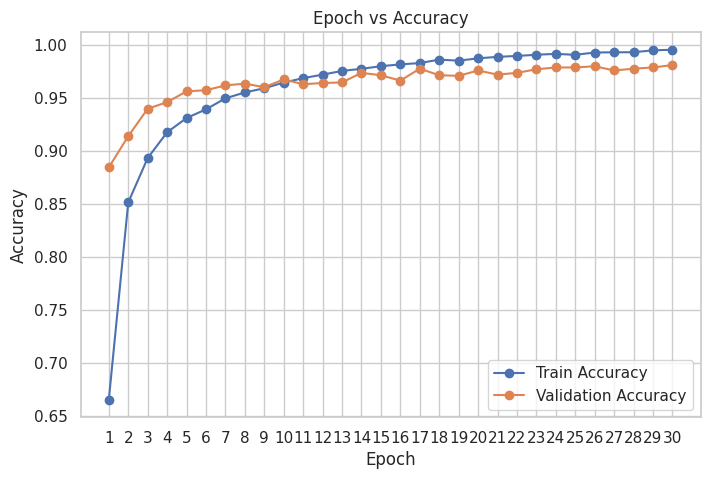

In [32]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], marker='o')
plt.plot(history.history["val_accuracy"], marker='o')
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(len(history.history["accuracy"])), range(1, len(history.history["accuracy"])+1))
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.grid(True)
plt.show()


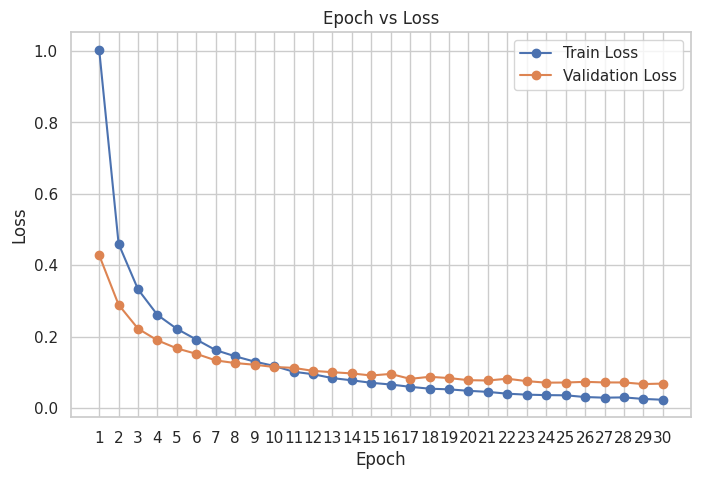

In [33]:
# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], marker='o')
plt.plot(history.history["val_loss"], marker='o')
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(history.history["loss"])), range(1, len(history.history["loss"])+1))
plt.legend(["Train Loss", "Validation Loss"])
plt.grid(True)
plt.show()


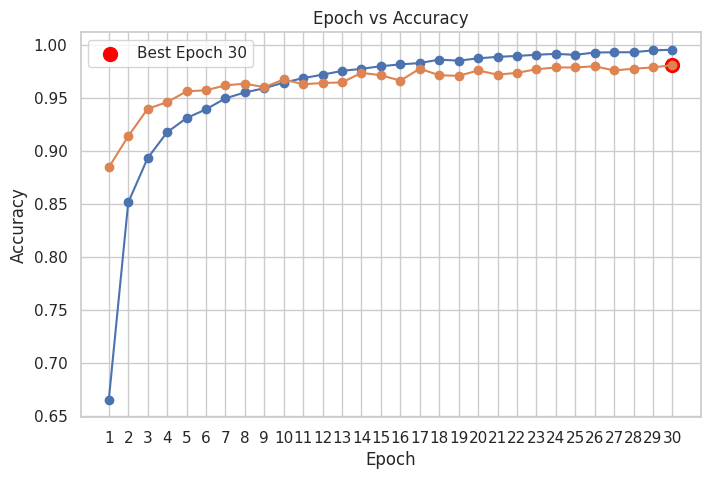

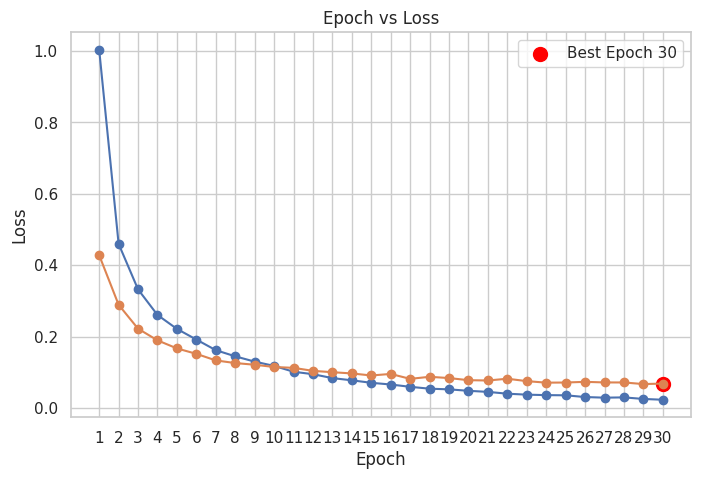

In [34]:
import matplotlib.pyplot as plt

# Best epoch info
best_epoch = history.history["val_accuracy"].index(
    max(history.history["val_accuracy"])
) + 1
best_val_acc = max(history.history["val_accuracy"])
best_val_loss = history.history["val_loss"][best_epoch-1]

# ---- Accuracy Plot ----
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], marker='o')
plt.plot(history.history["val_accuracy"], marker='o')
plt.scatter(best_epoch-1, best_val_acc, color='red', s=100, label=f'Best Epoch {best_epoch}')
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(len(history.history["accuracy"])), range(1, len(history.history["accuracy"])+1))
plt.legend()
plt.grid(True)
plt.show()

# ---- Loss Plot ----
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], marker='o')
plt.plot(history.history["val_loss"], marker='o')
plt.scatter(best_epoch-1, best_val_loss, color='red', s=100, label=f'Best Epoch {best_epoch}')
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(history.history["loss"])), range(1, len(history.history["loss"])+1))
plt.legend()
plt.grid(True)
plt.show()


In [35]:
# Example: Stable epoch detection
val_acc = history.history["val_accuracy"]
threshold = 0.005  # 0.5% tolerance
stable_epoch = None

for i in range(len(val_acc)-2, -1, -1):  # backwards
    if abs(val_acc[i+1] - val_acc[i]) < threshold:
        stable_epoch = i + 1  # Python index +1 for epoch number
    else:
        break

if stable_epoch:
    print(f"Stable Epoch starts at: {stable_epoch}")
    print(f"Validation Accuracy: {val_acc[stable_epoch-1]:.4f}")
else:
    print("No stable epoch detected")


Stable Epoch starts at: 20
Validation Accuracy: 0.9758


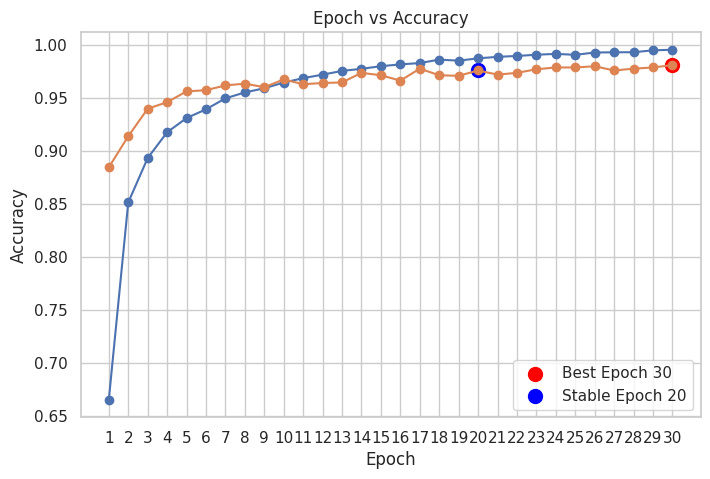

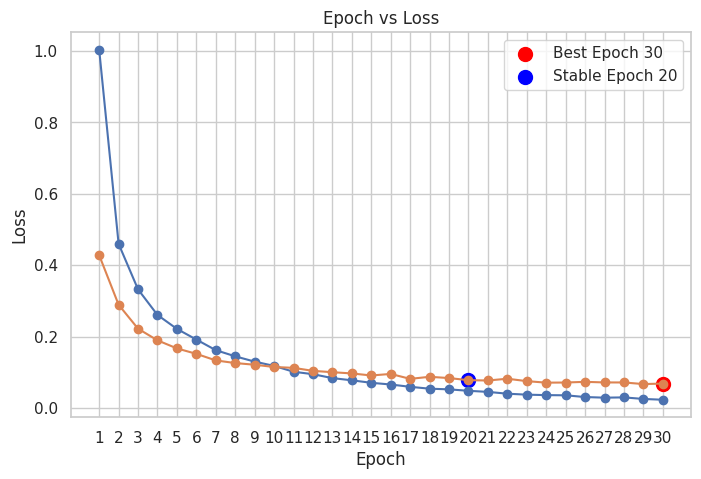

In [36]:
import matplotlib.pyplot as plt

# ---- Best epoch ----
best_epoch = history.history["val_accuracy"].index(
    max(history.history["val_accuracy"])
) + 1
best_val_acc = max(history.history["val_accuracy"])
best_val_loss = history.history["val_loss"][best_epoch-1]

# ---- Stable epoch ----
val_acc = history.history["val_accuracy"]
threshold = 0.005  # 0.5% tolerance
stable_epoch = None

# backward loop to find last stable point
for i in range(len(val_acc)-2, -1, -1):
    if abs(val_acc[i+1] - val_acc[i]) < threshold:
        stable_epoch = i + 1
    else:
        break

if stable_epoch:
    stable_val_acc = val_acc[stable_epoch-1]
    stable_val_loss = history.history["val_loss"][stable_epoch-1]
else:
    stable_val_acc = stable_val_loss = None

# ---- Accuracy Plot ----
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], marker='o')
plt.plot(history.history["val_accuracy"], marker='o')
plt.scatter(best_epoch-1, best_val_acc, color='red', s=100, label=f'Best Epoch {best_epoch}')
if stable_epoch:
    plt.scatter(stable_epoch-1, stable_val_acc, color='blue', s=100, label=f'Stable Epoch {stable_epoch}')
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(len(history.history["accuracy"])), range(1, len(history.history["accuracy"])+1))
plt.legend()
plt.grid(True)
plt.show()

# ---- Loss Plot ----
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], marker='o')
plt.plot(history.history["val_loss"], marker='o')
plt.scatter(best_epoch-1, best_val_loss, color='red', s=100, label=f'Best Epoch {best_epoch}')
if stable_epoch:
    plt.scatter(stable_epoch-1, stable_val_loss, color='blue', s=100, label=f'Stable Epoch {stable_epoch}')
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(history.history["loss"])), range(1, len(history.history["loss"])+1))
plt.legend()
plt.grid(True)
plt.show()


In [37]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
cross_epoch = None
for i in range(len(train_acc)-1, -1, -1):  # reverse loop
    if train_acc[i] < val_acc[i]:
        cross_epoch = i + 1
        break

if cross_epoch:
    print(f"Crosspoint detected at Epoch {cross_epoch}")
    print(f"Train Acc: {train_acc[cross_epoch-1]:.4f} | Val Acc: {val_acc[cross_epoch-1]:.4f}")
else:
    print("No crosspoint detected")



Crosspoint detected at Epoch 10
Train Acc: 0.9644 | Val Acc: 0.9673


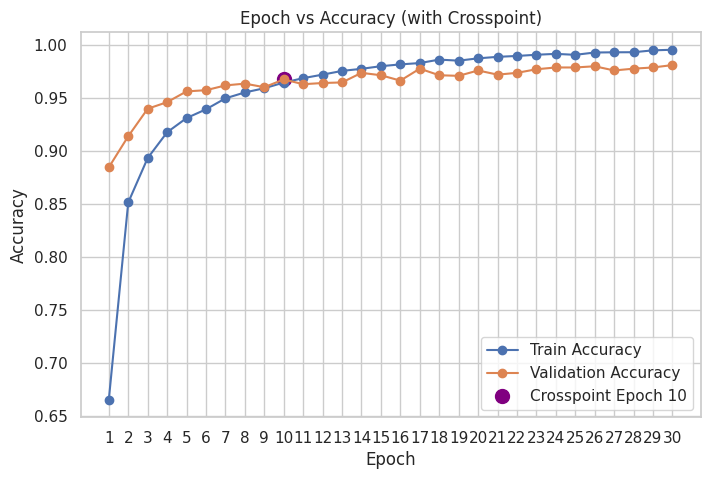

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_acc, marker='o', label="Train Accuracy")
plt.plot(val_acc, marker='o', label="Validation Accuracy")

if cross_epoch:
    plt.scatter(cross_epoch-1, val_acc[cross_epoch-1], color='purple', s=100, label=f'Crosspoint Epoch {cross_epoch}')

plt.title("Epoch vs Accuracy (with Crosspoint)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(len(train_acc)), range(1, len(train_acc)+1))
plt.legend()
plt.grid(True)
plt.show()


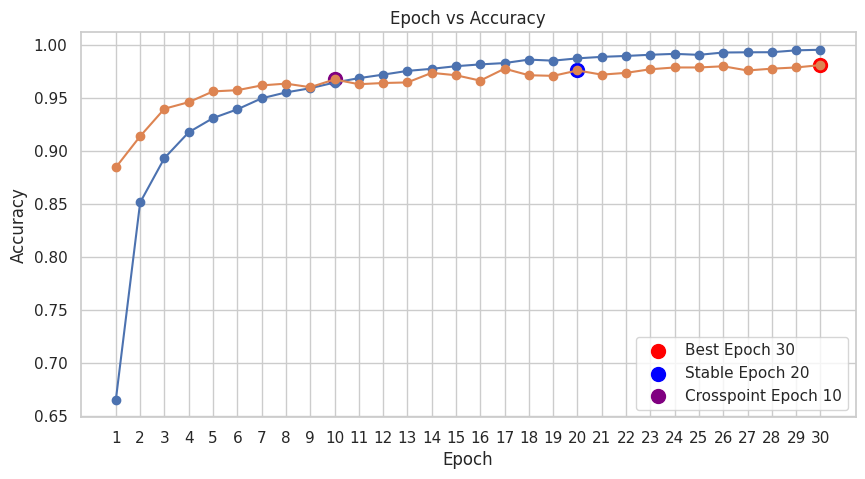

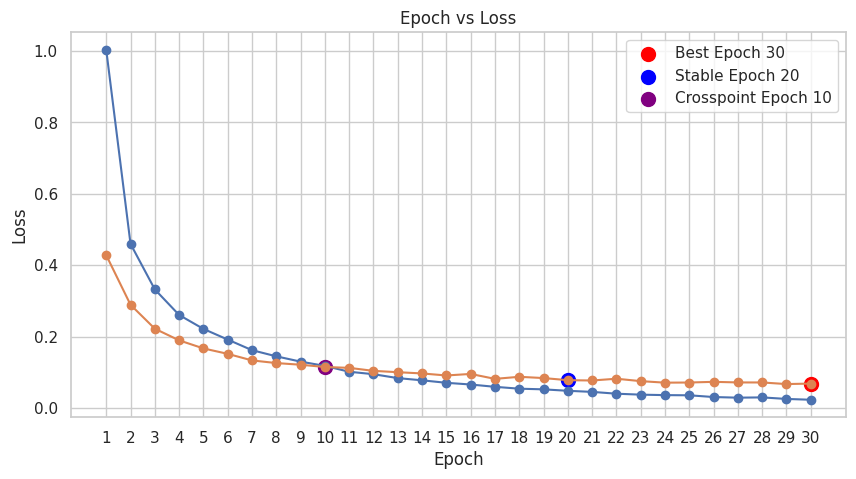

In [39]:
import matplotlib.pyplot as plt

# ---- Data ----
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# ---- Best epoch ----
best_epoch = val_acc.index(max(val_acc)) + 1
best_val_acc = val_acc[best_epoch-1]
best_val_loss = val_loss[best_epoch-1]

# ---- Stable epoch (last epoch where val_accuracy nearly constant) ----
threshold = 0.005  # 0.5% tolerance
stable_epoch = None
for i in range(len(val_acc)-2, -1, -1):
    if abs(val_acc[i+1] - val_acc[i]) < threshold:
        stable_epoch = i + 1
    else:
        break
if stable_epoch:
    stable_val_acc = val_acc[stable_epoch-1]
    stable_val_loss = val_loss[stable_epoch-1]

# ---- Crosspoint (latest epoch where train < val) ----
cross_epoch = None
for i in range(len(train_acc)-1, -1, -1):
    if train_acc[i] < val_acc[i]:
        cross_epoch = i + 1
        break
if cross_epoch:
    cross_val_acc = val_acc[cross_epoch-1]
    cross_val_loss = val_loss[cross_epoch-1]

# ---- Accuracy Plot ----
plt.figure(figsize=(10,5))
plt.plot(train_acc, marker='o')
plt.plot(val_acc, marker='o')
plt.scatter(best_epoch-1, best_val_acc, color='red', s=100, label=f'Best Epoch {best_epoch}')
if stable_epoch:
    plt.scatter(stable_epoch-1, stable_val_acc, color='blue', s=100, label=f'Stable Epoch {stable_epoch}')
if cross_epoch:
    plt.scatter(cross_epoch-1, cross_val_acc, color='purple', s=100, label=f'Crosspoint Epoch {cross_epoch}')
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(len(train_acc)), range(1, len(train_acc)+1))
plt.legend()
plt.grid(True)
plt.show()

# ---- Loss Plot ----
plt.figure(figsize=(10,5))
plt.plot(train_loss, marker='o')
plt.plot(val_loss, marker='o')
plt.scatter(best_epoch-1, best_val_loss, color='red', s=100, label=f'Best Epoch {best_epoch}')
if stable_epoch:
    plt.scatter(stable_epoch-1, stable_val_loss, color='blue', s=100, label=f'Stable Epoch {stable_epoch}')
if cross_epoch:
    plt.scatter(cross_epoch-1, cross_val_loss, color='purple', s=100, label=f'Crosspoint Epoch {cross_epoch}')
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(train_loss)), range(1, len(train_loss)+1))
plt.legend()
plt.grid(True)
plt.show()


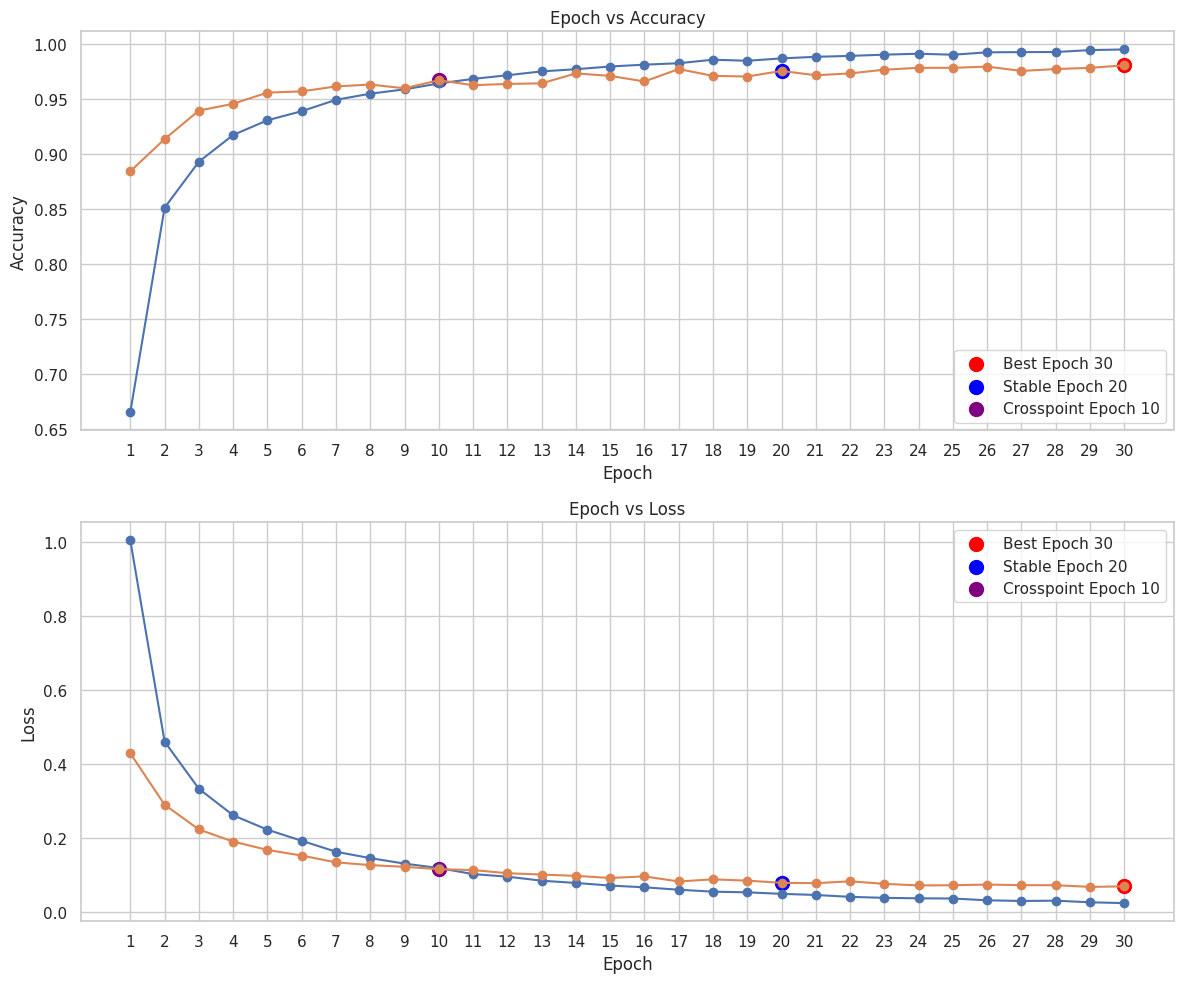

In [40]:
import matplotlib.pyplot as plt

# ---- Data ----
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# ---- Best epoch ----
best_epoch = val_acc.index(max(val_acc)) + 1
best_val_acc = val_acc[best_epoch-1]
best_val_loss = val_loss[best_epoch-1]

# ---- Stable epoch (last epoch where val_accuracy nearly constant) ----
threshold = 0.005  # 0.5% tolerance
stable_epoch = None
for i in range(len(val_acc)-2, -1, -1):
    if abs(val_acc[i+1] - val_acc[i]) < threshold:
        stable_epoch = i + 1
    else:
        break
if stable_epoch:
    stable_val_acc = val_acc[stable_epoch-1]
    stable_val_loss = val_loss[stable_epoch-1]

# ---- Crosspoint (latest epoch where train < val) ----
cross_epoch = None
for i in range(len(train_acc)-1, -1, -1):
    if train_acc[i] < val_acc[i]:
        cross_epoch = i + 1
        break
if cross_epoch:
    cross_val_acc = val_acc[cross_epoch-1]
    cross_val_loss = val_loss[cross_epoch-1]

# ---- Plotting ----
fig, axes = plt.subplots(2, 1, figsize=(12,10))

# ---- Accuracy subplot ----
axes[0].plot(train_acc, marker='o')
axes[0].plot(val_acc, marker='o')
axes[0].scatter(best_epoch-1, best_val_acc, color='red', s=100, label=f'Best Epoch {best_epoch}')
if stable_epoch:
    axes[0].scatter(stable_epoch-1, stable_val_acc, color='blue', s=100, label=f'Stable Epoch {stable_epoch}')
if cross_epoch:
    axes[0].scatter(cross_epoch-1, cross_val_acc, color='purple', s=100, label=f'Crosspoint Epoch {cross_epoch}')
axes[0].set_title("Epoch vs Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_xticks(range(len(train_acc)))
axes[0].set_xticklabels(range(1, len(train_acc)+1))
axes[0].legend()
axes[0].grid(True)

# ---- Loss subplot ----
axes[1].plot(train_loss, marker='o')
axes[1].plot(val_loss, marker='o')
axes[1].scatter(best_epoch-1, best_val_loss, color='red', s=100, label=f'Best Epoch {best_epoch}')
if stable_epoch:
    axes[1].scatter(stable_epoch-1, stable_val_loss, color='blue', s=100, label=f'Stable Epoch {stable_epoch}')
if cross_epoch:
    axes[1].scatter(cross_epoch-1, cross_val_loss, color='purple', s=100, label=f'Crosspoint Epoch {cross_epoch}')
axes[1].set_title("Epoch vs Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_xticks(range(len(train_loss)))
axes[1].set_xticklabels(range(1, len(train_loss)+1))
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Epoch 1/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5087 - loss: 1.5045
Epoch 1: val_accuracy improved from -inf to 0.88338, saving model to best_model.keras

Epoch 1: val_accuracy improved from -inf to 0.88338, saving model to best_model.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.5091 - loss: 1.5034 - val_accuracy: 0.8834 - val_loss: 0.4307
Epoch 2/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8333 - loss: 0.5076
Epoch 2: val_accuracy improved from 0.88338 to 0.91887, saving model to best_model.keras

Epoch 2: val_accuracy improved from 0.88338 to 0.91887, saving model to best_model.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.8333 - loss: 0.5075 - val_accuracy: 0.9189 - val_loss: 0.2854
Epoch 3/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8826 - loss: 0.3546
Epoch 3: val_accuracy improved from 0.91887 to 0.93746, saving model to best_model.keras

Epoch 3: val_accuracy improved from 0.91887 to 0.93746, saving model to best_model.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.8826 - loss: 0.3545 - val_accuracy: 0.9375 - val_loss: 0.2291
Epoch 4/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9093 - loss: 0.2765
Epoch 4: val_accuracy improved from 0.93746 to 0.94366, saving model to best_model.keras

Epoch 4: val_accuracy improved from 0.93746 to 0.94366, saving model to best_model.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9093 - loss: 0.2765 - val_accuracy: 0.9437 - val_loss: 0.1922
Epoch 5/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9271 - loss: 0.2311
Epoch 5: val_accuracy improved from 0.94366 to 0.94986, saving model to best_model.keras

Epoch 5: val_accuracy improved from 0.94366 to 0.94986, saving model to best_model.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9271 - loss: 0.2311 - val_accuracy: 0.9499 - val_loss: 0.1671
Epoch 6/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9425 - loss: 0.1867
Epoch 6: val_accuracy improved from 0.94986 to 0.95549, saving model to best_model.keras

Epoch 6: val_accuracy improved from 0.94986 to 0.95549, saving model to best_model.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9425 - loss: 0.1868 - val_accuracy: 0.9555 - val_loss: 0.1505
Epoch 7/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9469 - loss: 0.1670
Epoch 7: val_accuracy improved from 0.95549 to 0.95887, saving model to best_model.keras

Epoch 7: val_accuracy improved from 0.95549 to 0.95887, saving model to best_model.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9469 - loss: 0.1670 - val_accuracy: 0.9589 - val_loss: 0.1357
Epoch 8/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9487 - loss: 0.1554
Epoch 8: val_accuracy did not improve from 0.95887

Epoch 8: val_accuracy did not improve from 0.95887
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9487 - loss: 0.1554 - val_accuracy: 0.9572 - val_loss: 0.1320
Epoch 9/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9560 - loss: 0.1433
Epoch 9: val_accuracy improved from 0.95887 to 0.96845, saving model to best_model.keras

Epoch 9: val_accuracy improved from 0.95887 to 0.96845, saving model to best_model.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9560 - loss: 0.1433 - val_accuracy: 0.9685 - val_loss: 0.1172
Epoch 10/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9648 - loss: 0.1217
Epoch 10: val_accuracy did not improve from 0.96845

Epoch 10: val_accuracy did not improve from 0.96845
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9648 - loss: 0.1217 - val_accuracy: 0.9645 - val_loss: 0.1106
Epoch 11/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9668 - loss: 0.1056
Epoch 11: val_accuracy did not improve from 0.96845

Epoch 11: val_accuracy did not improve from 0.96845
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9668 - loss: 0.1056 - val_accuracy: 0.9662 - val_loss: 0.1065
Epoch 12/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9691 - loss: 0.1047
Epoch 12: val_accuracy did not improve from 0.96845

Epoch 12: val_accuracy did not improve from 0.96845
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9691 - 

444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9738 - loss: 0.0915 - val_accuracy: 0.9718 - val_loss: 0.0935
Epoch 14/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9740 - loss: 0.0860
Epoch 14: val_accuracy did not improve from 0.97183

Epoch 14: val_accuracy did not improve from 0.97183
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9740 - loss: 0.0860 - val_accuracy: 0.9685 - val_loss: 0.0959
Epoch 15/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9765 - loss: 0.0809
Epoch 15: val_accuracy did not improve from 0.97183

Epoch 15: val_accuracy did not improve from 0.97183
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9765 - loss: 0.0808 - val_accuracy: 0.9718 - val_loss: 0.0877
Epoch 16/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9824 - loss: 0.0672
Epoch 16: val_accuracy improved from 0.97183 to 0.97296, saving model to best_model.keras

Epoch 16: val_accuracy improved from 0.97183 to 0.97296, saving model to best_

444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9824 - loss: 0.0672 - val_accuracy: 0.9730 - val_loss: 0.0859
Epoch 17/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9817 - loss: 0.0657
Epoch 17: val_accuracy improved from 0.97296 to 0.97634, saving model to best_model.keras

Epoch 17: val_accuracy improved from 0.97296 to 0.97634, saving model to best_model.h5


444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9817 - loss: 0.0657 - val_accuracy: 0.9763 - val_loss: 0.0819
Epoch 18/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9845 - loss: 0.0577
Epoch 18: val_accuracy did not improve from 0.97634

Epoch 18: val_accuracy did not improve from 0.97634
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9845 - loss: 0.0577 - val_accuracy: 0.9730 - val_loss: 0.0858
Epoch 19/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9849 - loss: 0.0531
Epoch 19: val_accuracy did not improve from 0.97634

Epoch 19: val_accuracy did not improve from 0.97634
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9849 - loss: 0.0531 - val_accuracy: 0.9730 - val_loss: 0.0786
Epoch 20/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9865 - loss: 0.0485
Epoch 20: val_accuracy improved from 0.97634 to 0.97915, saving model to best_model.keras

Epoch 20: val_accuracy improved from 0.97634 to 0.97915, saving model to best_

444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9865 - loss: 0.0485 - val_accuracy: 0.9792 - val_loss: 0.0756
Epoch 21/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9888 - loss: 0.0456
Epoch 21: val_accuracy did not improve from 0.97915

Epoch 21: val_accuracy did not improve from 0.97915
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9888 - loss: 0.0456 - val_accuracy: 0.9763 - val_loss: 0.0799
Epoch 22/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9893 - loss: 0.0412
Epoch 22: val_accuracy did not improve from 0.97915

Epoch 22: val_accuracy did not improve from 0.97915
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9893 - loss: 0.0412 - val_accuracy: 0.9735 - val_loss: 0.0797
Epoch 23/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9879 - loss: 0.0400
Epoch 23: val_accuracy did not improve from 0.97915

Epoch 23: val_accuracy did not improve from 0.97915
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9879 - 

444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9922 - loss: 0.0302 - val_accuracy: 0.9814 - val_loss: 0.0676
Epoch 29/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9928 - loss: 0.0288
Epoch 29: val_accuracy did not improve from 0.98141

Epoch 29: val_accuracy did not improve from 0.98141
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9928 - loss: 0.0288 - val_accuracy: 0.9775 - val_loss: 0.0692
Epoch 30/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9947 - loss: 0.0248
Epoch 30: val_accuracy did not improve from 0.98141

Epoch 30: val_accuracy did not improve from 0.98141
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9947 - loss: 0.0248 - val_accuracy: 0.9752 - val_loss: 0.0712
Epoch 31/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9946 - loss: 0.0228
Epoch 31: val_accuracy improved from 0.98141 to 0.98197, saving model to best_model.keras

Epoch 31: val_accuracy improved from 0.98141 to 0.98197, saving model to best_

444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9946 - loss: 0.0228 - val_accuracy: 0.9820 - val_loss: 0.0696
Epoch 32/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9938 - loss: 0.0247
Epoch 32: val_accuracy did not improve from 0.98197

Epoch 32: val_accuracy did not improve from 0.98197
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9938 - loss: 0.0247 - val_accuracy: 0.9792 - val_loss: 0.0681
Epoch 33/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9948 - loss: 0.0235
Epoch 33: val_accuracy did not improve from 0.98197

Epoch 33: val_accuracy did not improve from 0.98197
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9948 - loss: 0.0235 - val_accuracy: 0.9735 - val_loss: 0.0717
Epoch 34/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9945 - loss: 0.0219
Epoch 34: val_accuracy did not improve from 0.98197

Epoch 34: val_accuracy did not improve from 0.98197
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9945 - 

444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9938 - loss: 0.0206 - val_accuracy: 0.9842 - val_loss: 0.0614
Epoch 37/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9972 - loss: 0.0148
Epoch 37: val_accuracy did not improve from 0.98423

Epoch 37: val_accuracy did not improve from 0.98423
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9972 - loss: 0.0148 - val_accuracy: 0.9814 - val_loss: 0.0642
Epoch 38/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9957 - loss: 0.0173
Epoch 38: val_accuracy did not improve from 0.98423

Epoch 38: val_accuracy did not improve from 0.98423
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9957 - loss: 0.0173 - val_accuracy: 0.9769 - val_loss: 0.0744
Epoch 39/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9965 - loss: 0.0154
Epoch 39: val_accuracy did not improve from 0.98423

Epoch 39: val_accuracy did not improve from 0.98423
444/444 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9965 - 

444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9973 - loss: 0.0124 - val_accuracy: 0.9848 - val_loss: 0.0600
Epoch 45/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9968 - loss: 0.0120
Epoch 45: val_accuracy did not improve from 0.98479

Epoch 45: val_accuracy did not improve from 0.98479
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9968 - loss: 0.0120 - val_accuracy: 0.9808 - val_loss: 0.0668
Epoch 46/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9977 - loss: 0.0116
Epoch 46: val_accuracy did not improve from 0.98479

Epoch 46: val_accuracy did not improve from 0.98479
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9977 - loss: 0.0116 - val_accuracy: 0.9775 - val_loss: 0.0749
Epoch 47/50
443/444 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9987 - loss: 0.0104
Epoch 47: val_accuracy did not improve from 0.98479

Epoch 47: val_accuracy did not improve from 0.98479
444/444 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9987 - 

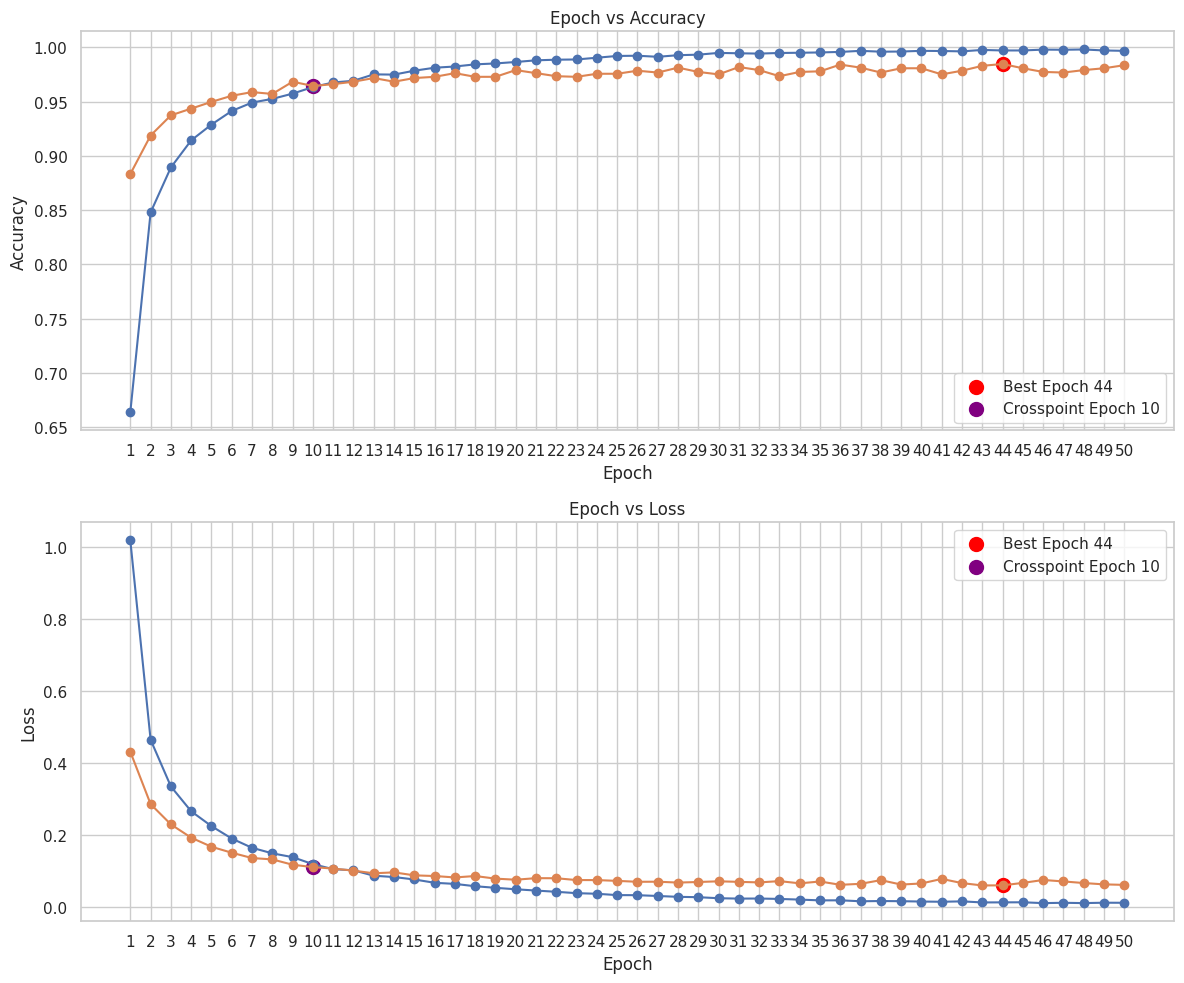

In [41]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# ---- Parameters ----
FINAL_EPOCHS = 50
STABLE_THRESHOLD = 0.002  # ±0.2% for stable epoch

# ---- ModelCheckpoint ----
checkpoint_keras = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

checkpoint_h5 = ModelCheckpoint(
    filepath="best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# ---- Build model ----
final_model = build_model(cnn_models["ResNet50"], trainable=False)

# ---- Train model ----
history = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINAL_EPOCHS,
    callbacks=[checkpoint_keras, checkpoint_h5],
    verbose=1
)

# ---- Extract metrics ----
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# ---- Best epoch ----
best_epoch = val_acc.index(max(val_acc)) + 1
best_val_acc = val_acc[best_epoch-1]
best_val_loss = val_loss[best_epoch-1]

# ---- Stable epoch (last epoch where val_accuracy nearly constant) ----
stable_epoch = None
for i in range(len(val_acc)-2, -1, -1):
    if abs(val_acc[i+1] - val_acc[i]) < STABLE_THRESHOLD:
        stable_epoch = i + 1
    else:
        break
if stable_epoch:
    stable_val_acc = val_acc[stable_epoch-1]
    stable_val_loss = val_loss[stable_epoch-1]

# ---- Crosspoint (latest epoch where train < val) ----
cross_epoch = None
for i in range(len(train_acc)-1, -1, -1):
    if train_acc[i] < val_acc[i]:
        cross_epoch = i + 1
        break
if cross_epoch:
    cross_val_acc = val_acc[cross_epoch-1]
    cross_val_loss = val_loss[cross_epoch-1]

# ---- Print Epoch-wise Report ----
print("\nEpoch-wise Training Report")
print("-"*60)
for i in range(len(train_acc)):
    print(
        f"Epoch {i+1:02d} | "
        f"Train Acc: {train_acc[i]:.4f} | Val Acc: {val_acc[i]:.4f} | "
        f"Train Loss: {train_loss[i]:.4f} | Val Loss: {val_loss[i]:.4f}"
    )

print("\nBest Epoch Summary")
print("-"*30)
print(f"Best Epoch       : {best_epoch} | Val Acc: {best_val_acc:.4f}")

if stable_epoch:
    print(f"Stable Epoch     : {stable_epoch} | Val Acc: {stable_val_acc:.4f}")

if cross_epoch:
    print(f"Crosspoint Epoch : {cross_epoch} | Train Acc < Val Acc: {cross_val_acc:.4f}")

# ---- Combined Accuracy & Loss Plot ----
fig, axes = plt.subplots(2, 1, figsize=(12,10))

# Accuracy subplot
axes[0].plot(train_acc, marker='o')
axes[0].plot(val_acc, marker='o')
axes[0].scatter(best_epoch-1, best_val_acc, color='red', s=100, label=f'Best Epoch {best_epoch}')
if stable_epoch:
    axes[0].scatter(stable_epoch-1, stable_val_acc, color='blue', s=100, label=f'Stable Epoch {stable_epoch}')
if cross_epoch:
    axes[0].scatter(cross_epoch-1, cross_val_acc, color='purple', s=100, label=f'Crosspoint Epoch {cross_epoch}')
axes[0].set_title("Epoch vs Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_xticks(range(len(train_acc)))
axes[0].set_xticklabels(range(1, len(train_acc)+1))
axes[0].legend()
axes[0].grid(True)

# Loss subplot
axes[1].plot(train_loss, marker='o')
axes[1].plot(val_loss, marker='o')
axes[1].scatter(best_epoch-1, best_val_loss, color='red', s=100, label=f'Best Epoch {best_epoch}')
if stable_epoch:
    axes[1].scatter(stable_epoch-1, stable_val_loss, color='blue', s=100, label=f'Stable Epoch {stable_epoch}')
if cross_epoch:
    axes[1].scatter(cross_epoch-1, cross_val_loss, color='purple', s=100, label=f'Crosspoint Epoch {cross_epoch}')
axes[1].set_title("Epoch vs Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_xticks(range(len(train_loss)))
axes[1].set_xticklabels(range(1, len(train_loss)+1))
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
